In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Zad. 
Zastosujmy algorytmy:
 * k-średnie, 
 * DBSCAN, 
 * hierarchiczne klastrowanie 

dla zbioru danych zawierającego zdjęcia twarzy. 

In [4]:
from sklearn.datasets import fetch_lfw_people

In [5]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

Narysujmy kilka zdjęć oraz ich etykiety.

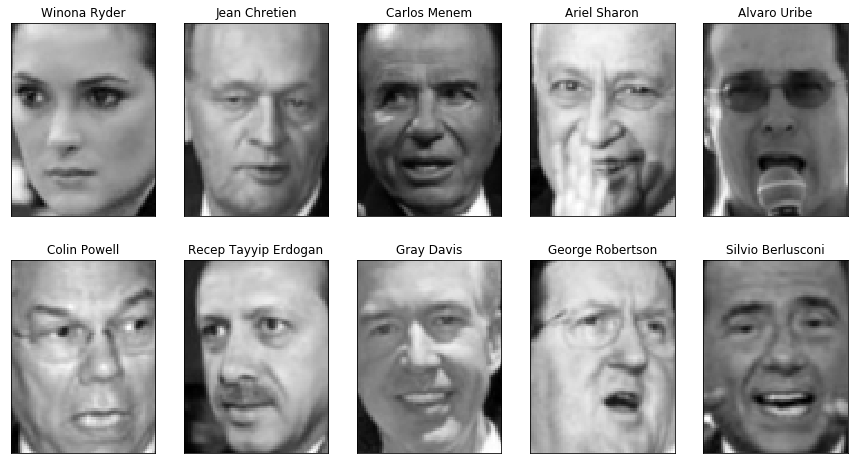

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=plt.cm.gist_gray)
    ax.set_title(people.target_names[target])
plt.show()   

In [12]:
people.images[0].shape
87*65

5655

Wypisz wymiar danych oraz ilość grup.

**UWAGA! W naszej analizie zakładamy, że nie znamy ilości grup.**

In [13]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [14]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [20]:
# X_people
people.images.shape
X_people = people.images.reshape(3023, -1)
X_people.shape

(3023, 5655)

Zawsze warto zwizualizować dane za pomocą t-SNE.

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
X_people_tsne = tsne.fit_transform(X_people)

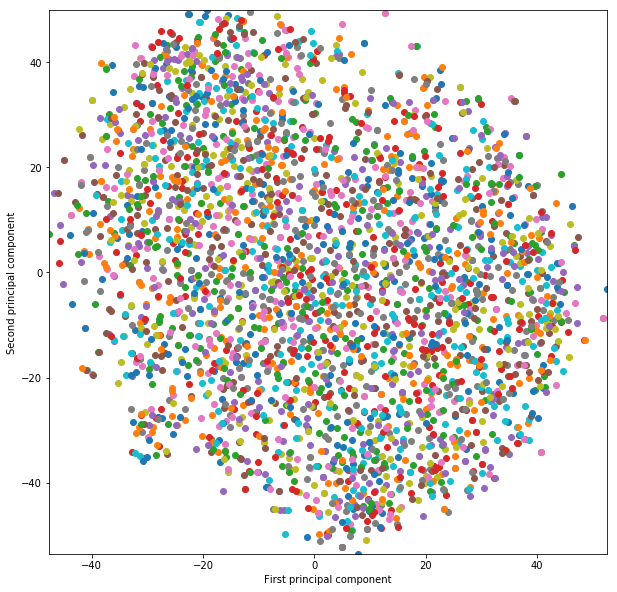

In [23]:
from matplotlib import colors as mcolors

colors = list(mcolors.CSS4_COLORS)
plt.figure(figsize=(10, 10))
plt.xlim(X_people_tsne[:, 0].min(), X_people_tsne[:, 0].max())
plt.ylim(X_people_tsne[:, 1].min(), X_people_tsne[:, 1].max())
for i in range(len(X_people)):
    # actually plot the digits as text instead of using scatter
    plt.scatter(X_people_tsne[i, 0], X_people_tsne[i, 1])
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

Wczytaj dane i zaprezentuj je jako macierze:

   * X_people, 
   * y_people,

zawierające odpowiednie dane i przydziały do grup.

In [24]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

In [25]:
X_people.shape

(2063, 5655)

Pamiętaj o przeskalowaniu danych, np.

```python
X_people = X_people / 255.
```


In [26]:
# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

Będziemy używać reprezentacji danych otrzymanych przez PCA (whiten = True), ze 100 komponentami:

In [27]:
# extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [28]:
X_pca.shape

(2063, 100)

## Analiza zdjęć twarzy za pomocą algorytmu DBSCAN

Powinniśmy narysować histogram odległości pomiędzy punktami, aby wiedzieć jakie wartości parametrów wybrać.


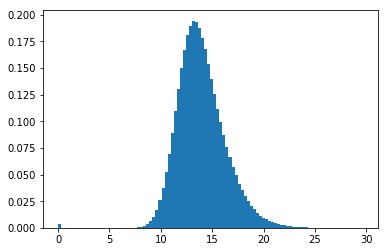

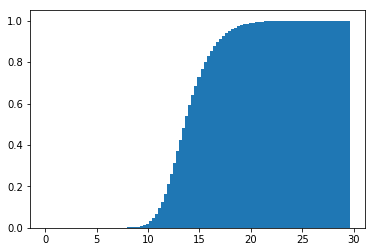

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
x = euclidean_distances(X_pca, X_pca)

# wybieramy tylko część pod przekątną
xx = x[np.tril_indices(x.shape[0])]

plt.hist(xx,density=True, bins=100)#,cumulative=True
plt.show()
plt.hist(xx,density=True, bins=100, cumulative=True)
plt.show()

Możemy zacząć od wypisania ile otrzymamy klastrów gdy podamy kilka różnych parametrów:
   
   * DBSCAN(),
   * DBSCAN(min_samples=3),
   * DBSCAN(min_samples=3, eps=15).

In [10]:
# apply DBSCAN with default parameters# apply  
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


In [11]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


In [52]:
for i in np.arange(2, 25):
    for j in np.arange(2, 25):
        print(i)
        print(j)
        dbscan = DBSCAN(min_samples=i, eps=j)
        labels = dbscan.fit_predict(X_pca)
        print("Unique labels: {}".format(np.unique(labels)))

2
2
Unique labels: [-1  0]
2
3
Unique labels: [-1  0]
2
4
Unique labels: [-1  0]
2
5
Unique labels: [-1  0  1  2]
2
6
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10]
2
7
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
2
8
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31]
2
9
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
2
10
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
2
11
Unique labels: [-1  0  1  2  3  4  5  6  7  8]
2
12
Unique labels: [-1  0  1  2]
2
13
Unique labels: [-1  0]
2
14
Unique labels: [-1  0  1  2]
2
15
Unique labels: [-1  0  1]
2
16
Unique labels: [-1  0  1]
2
17
Unique labels: [-1  0]
2
18
Unique labels: [-1  0]
2
19
Unique labels: [-1  0]
2
20
Unique labels: [0]
2
21
Unique labels: [0]
2
22
Unique

KeyboardInterrupt: 

In [53]:
dbscan = DBSCAN(min_samples=3, eps=8)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0  1  2  3  4]


In [54]:
# count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# the first number in the result corresponds to noise points
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [1760  287    5    3    5    3]


Możemy narysować wszystkie twarze, które zostały zakwalifikowane jako szum.

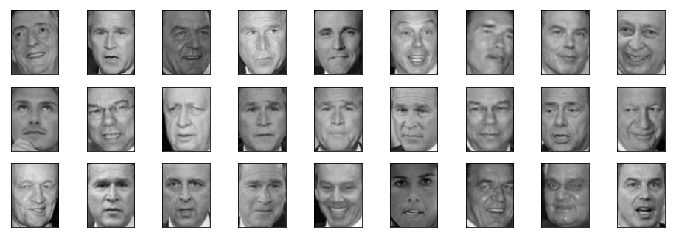

In [57]:
noise = X_people[labels==0]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
plt.show()    

Wybierzmy kilka parametrów: 

   * eps = 1, 3, 5, 7, 9, 11, 13 
   
i wypiszmy ile otrzymujemy wtedy klastrów wraz z licznościami.    

In [17]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Number of clusters: 1
Cluster sizes: [2063]

eps=3
Number of clusters: 1
Cluster sizes: [2063]

eps=5
Number of clusters: 1
Cluster sizes: [2063]

eps=7
Number of clusters: 14
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Number of clusters: 4
Cluster sizes: [1307  750    3    3]

eps=11
Number of clusters: 2
Cluster sizes: [ 413 1650]

eps=13
Number of clusters: 2
Cluster sizes: [ 120 1943]


Wybierzmy optymalny parametr: 

```python
DBSCAN(min_samples=3, eps=7)
```

i narysujmy wszystkie elementy w klastrach.

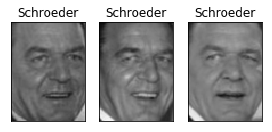

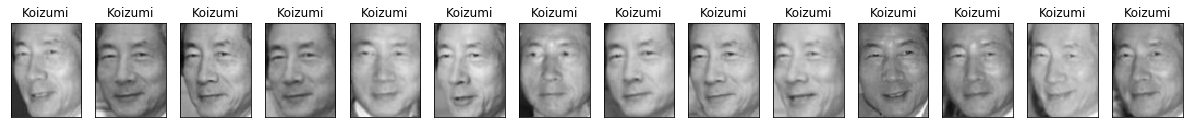

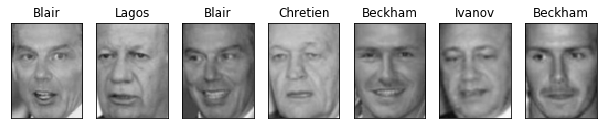

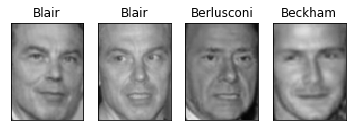

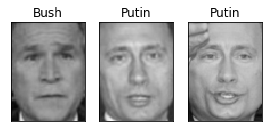

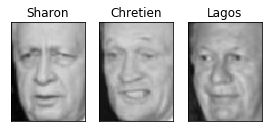

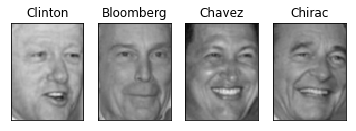

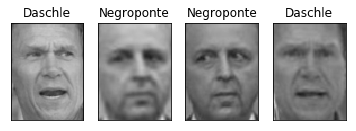

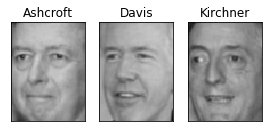

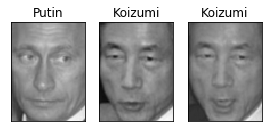

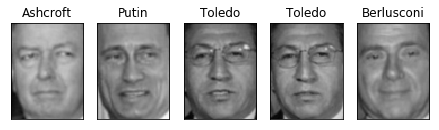

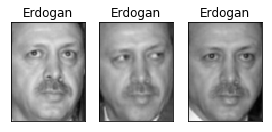

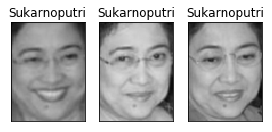

In [24]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):

        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
        ax.set_title(people.target_names[label].split()[-1])
plt.show()        

# Analiza zdjęć twarzy za pomocą algorytmu k-Means

Wykonajmy algorytm k-means z parametrami:

```python 
km = KMeans(n_clusters=10, random_state=0)
```

i wypiszmy ilość elementów w grupach.

In [64]:
# extract clusters with k-Means
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [155 175 238  75 358 257  91 219 323 172]


Narysujmy środki grup.

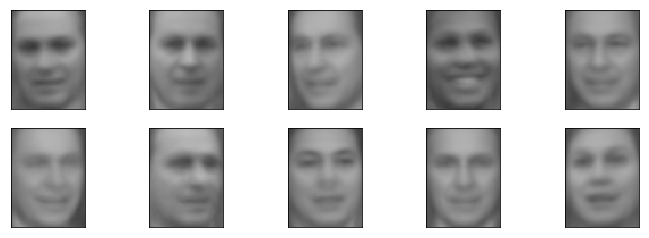

In [65]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1, cmap=plt.cm.gist_gray)
plt.show()    

Narysujmy w tabeli:
  * środki grup,
  * najbliższe elementy w grupach,
  * najdalsze elementy w grupach.

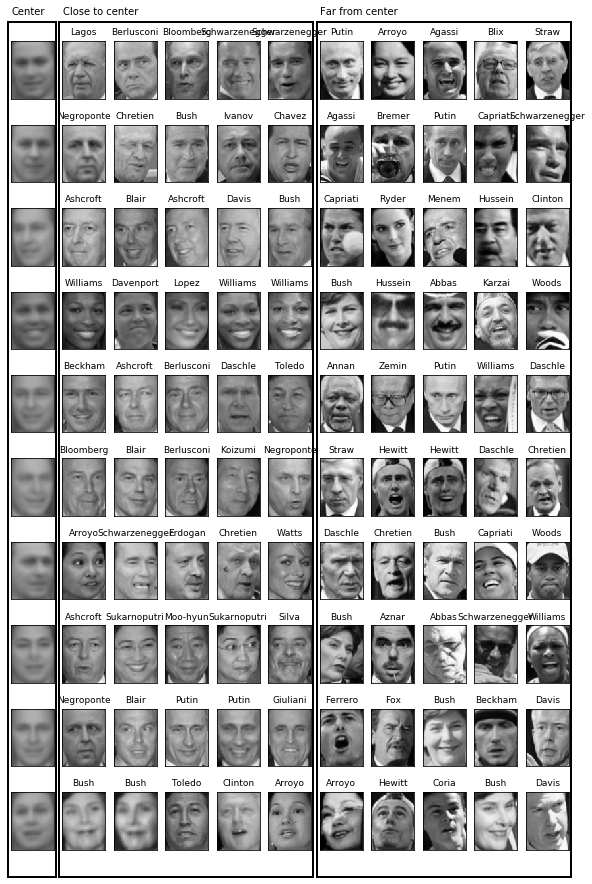

In [66]:
n_clusters = 10
image_shape = (87, 65)
fig, axes = plt.subplots(n_clusters, 11, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(10, 15), gridspec_kw={"hspace": .3})

for cluster in range(n_clusters):
    center = km.cluster_centers_[cluster]
    mask = km.labels_ == cluster
    dists = np.sum((X_pca - center) ** 2, axis=1)
    dists[~mask] = np.inf
    inds = np.argsort(dists)[:5]
    dists[~mask] = -np.inf
    inds = np.r_[inds, np.argsort(dists)[-5:]]
    axes[cluster, 0].imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
    for image, label, asdf, ax in zip(X_people[inds], y_people[inds],
                                      km.labels_[inds], axes[cluster, 1:]):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
        ax.set_title("%s" % (people.target_names[label].split()[-1]), fontdict={'fontsize': 9})

# add some boxes to illustrate which are similar and which dissimilar
rec = plt.Rectangle([-5, -30], 73, 1295, fill=False, lw=2)
rec = axes[0, 0].add_patch(rec)
rec.set_clip_on(False)
axes[0, 0].text(0, -40, "Center")

rec = plt.Rectangle([-5, -30], 385, 1295, fill=False, lw=2)
rec = axes[0, 1].add_patch(rec)
rec.set_clip_on(False)
axes[0, 1].text(0, -40, "Close to center")

rec = plt.Rectangle([-5, -30], 385, 1295, fill=False, lw=2)
rec = axes[0, 6].add_patch(rec)
rec.set_clip_on(False)
axes[0, 6].text(0, -40, "Far from center")
plt.show()

Możemy dobrać optymalną ilosć grup za pomocą metody Elbow:

C:\Users\przem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


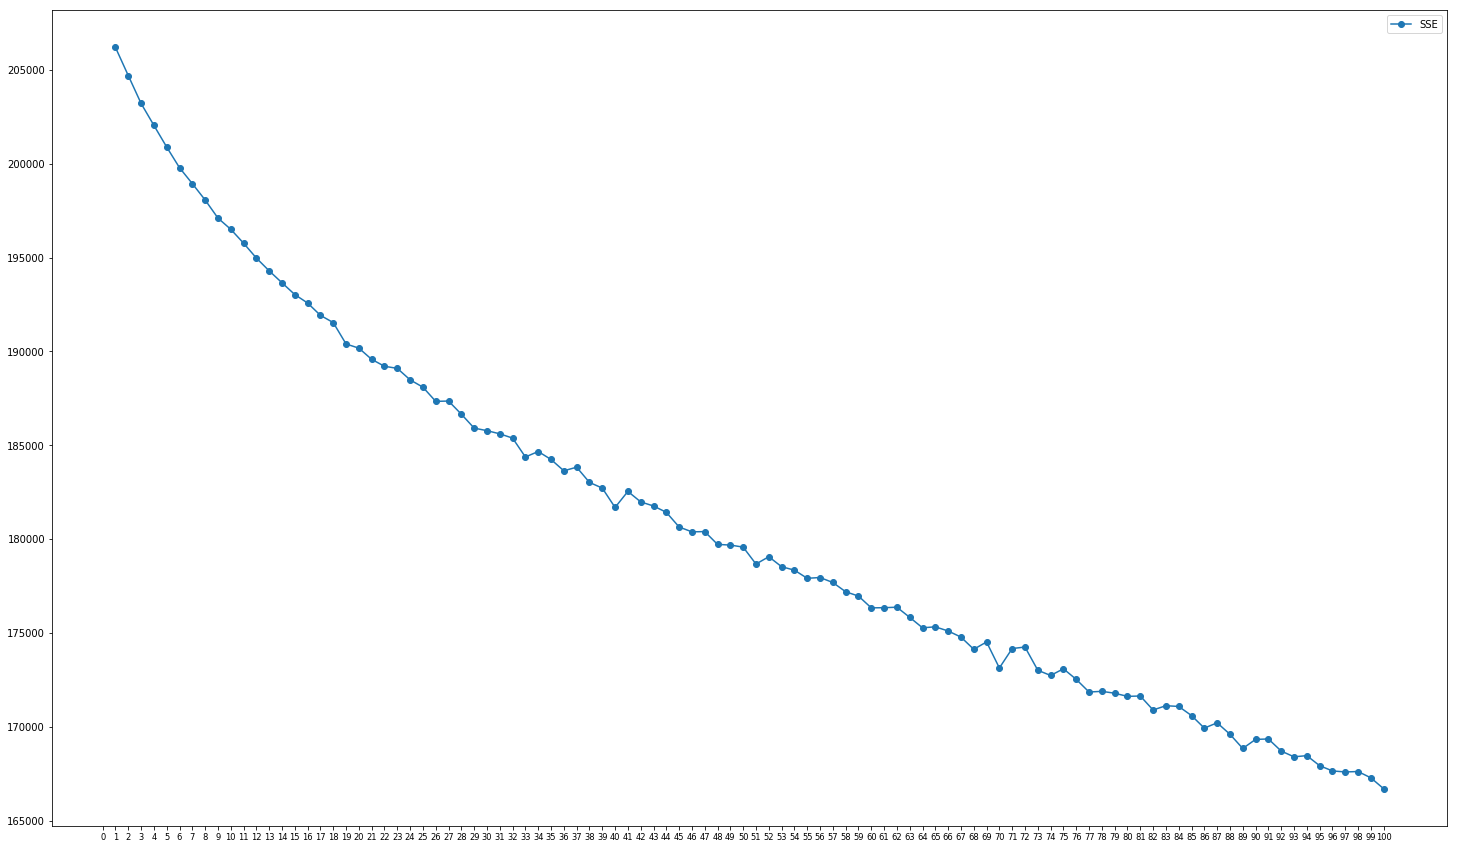

In [67]:
SSE_array = [None]
    
for i in range(1,101):
    km = KMeans(n_clusters=i, n_init=10)
    y_km = km.fit_predict(X_pca)
    SSE_array.append(km.inertia_)
    
t=range(0,101)
plt.figure(figsize=(25,15))
plt.plot(SSE_array, "o-", label="SSE")
plt.xticks(range(len(t)), t, size='small')
plt.legend()
plt.show()    

Możemy też wykorzystać silhouette_score.

C:\Users\przem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


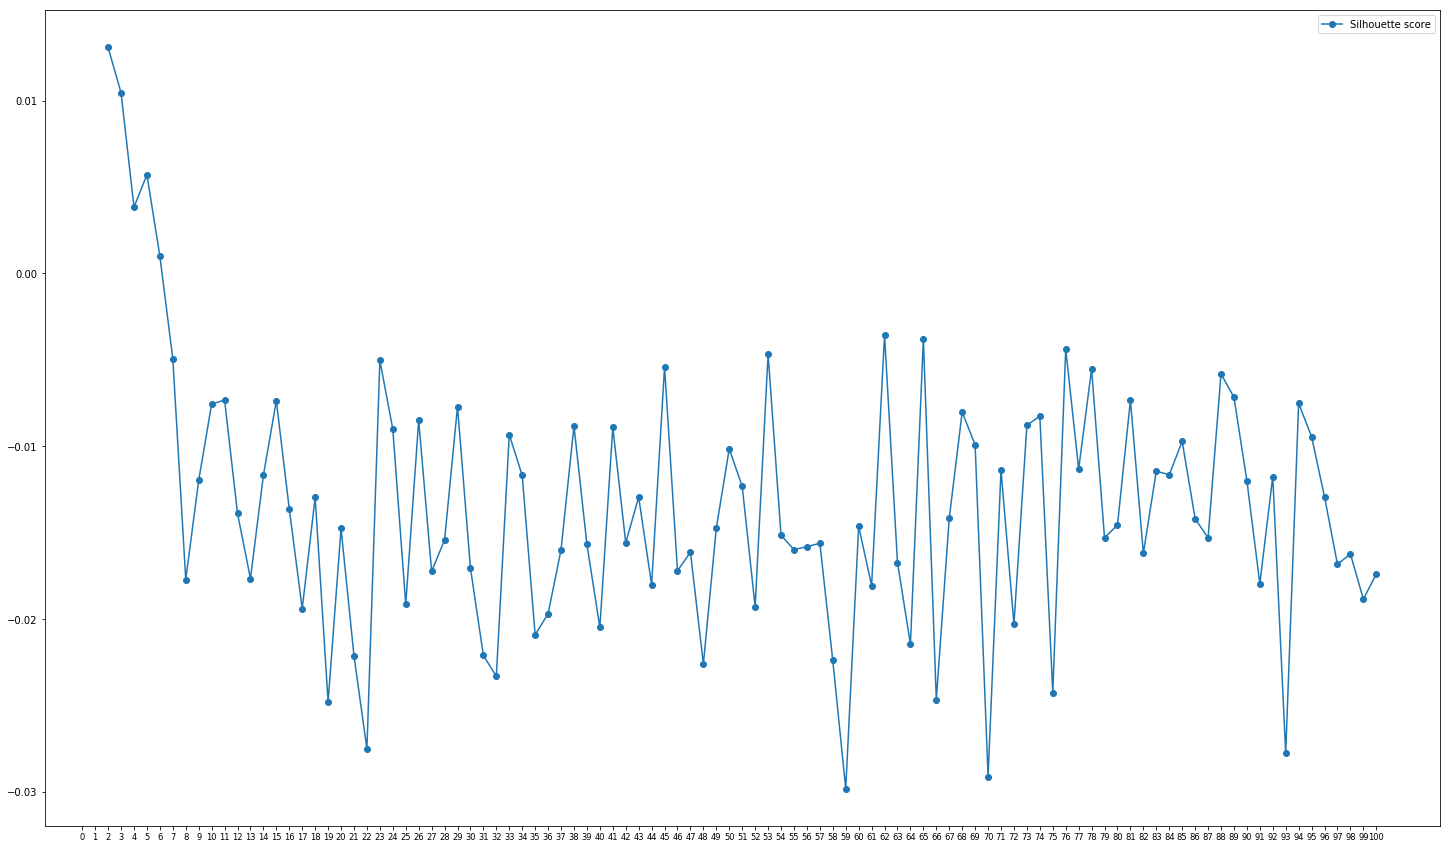

In [68]:
from sklearn.metrics import silhouette_score

silhouette_score_array = [None, None]
    
for i in range(2,101):
    km = KMeans(n_clusters=i, n_init=10)
    y_km = km.fit_predict(X_pca)
    silhouette_score_array.append( silhouette_score(X_pca,km.labels_) )
    
t=range(0,101)

plt.figure(figsize=(25,15));
plt.plot(silhouette_score_array, "o-", label="Silhouette score")
plt.xticks(range(len(t)), t, size='small')
plt.legend()
plt.show()    

Możemy narysować wykres silhouette_samples.

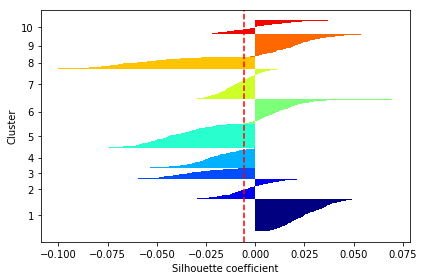

In [45]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=10)
y_km = km.fit_predict(X_pca)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_pca, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

# Analiza zdjęć twarzy za pomocą algorytmu agglomerative clustering

Możemy wykonać algorytm: 
  * AgglomerativeClustering
  
```python
AgglomerativeClustering(n_clusters=10)
```

In [86]:
# extract clusters with ward agglomerative clustering# extrac 
agglomerative = AgglomerativeClustering(n_clusters=1000, linkage ='average')
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

cluster sizes agglomerative clustering: [  2   3   7  14   3   9 408   2   4   4   5   5   3   5   8   3   3  11
   2   4   3   2   2   3   4   4   7   9   8   3   2   2   3   4   7   2
   2   3   3   2   3   8   5   5   3   2   3   2   3   4   4   2   5   6
   4   2  12   9   7   3  12   2   4   2   3   3   2   2   2   3   2   3
   5   2   5   8   5   3   2   2   4   2   6   2   3   4   3   2   2   2
   2   2   2   2   2   2   2   8   2   5   8   2   3   4   2   2   3   6
   2   7   2   5  12   2   3   2   2   2   2   3   2   3   3   9   5   1
   1   1   1   2   1   1   2   2   1   1   2   1   1   2   2   3   3   2
   1   1   2   1   1   2   4   1   2   8   2   2   5   2   2   1   1   2
   3   2   2   2   3   1   3   2   2   2   1   3   2   1   2   2   6   2
   2   1   1  10   2   2   2   2   3   2   2   2   3   3   3   1   2   1
   1   1   3   4   2   1   2   2   2   4   3   2   5   2   2   2   2   2
   5   3   2   1   1   2   3   4   4   2   5   2   2   2   4   4   2   2
   6   2  1

Możemy wykonać grupowanie za pomocą: 

```python
scipy
```

i narysować dendrogram.

In [76]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

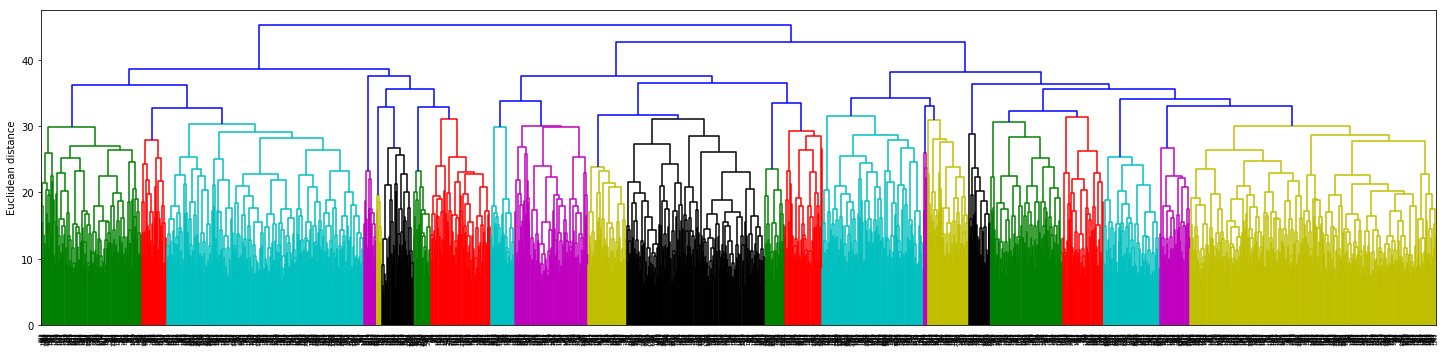

In [77]:
df = pd.DataFrame(X_pca)
df
   
plt.figure(figsize=(20, 5))
row_clusters = linkage(pdist(df, metric='euclidean'), method='ward') 
row_dendr = dendrogram(row_clusters)

plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()


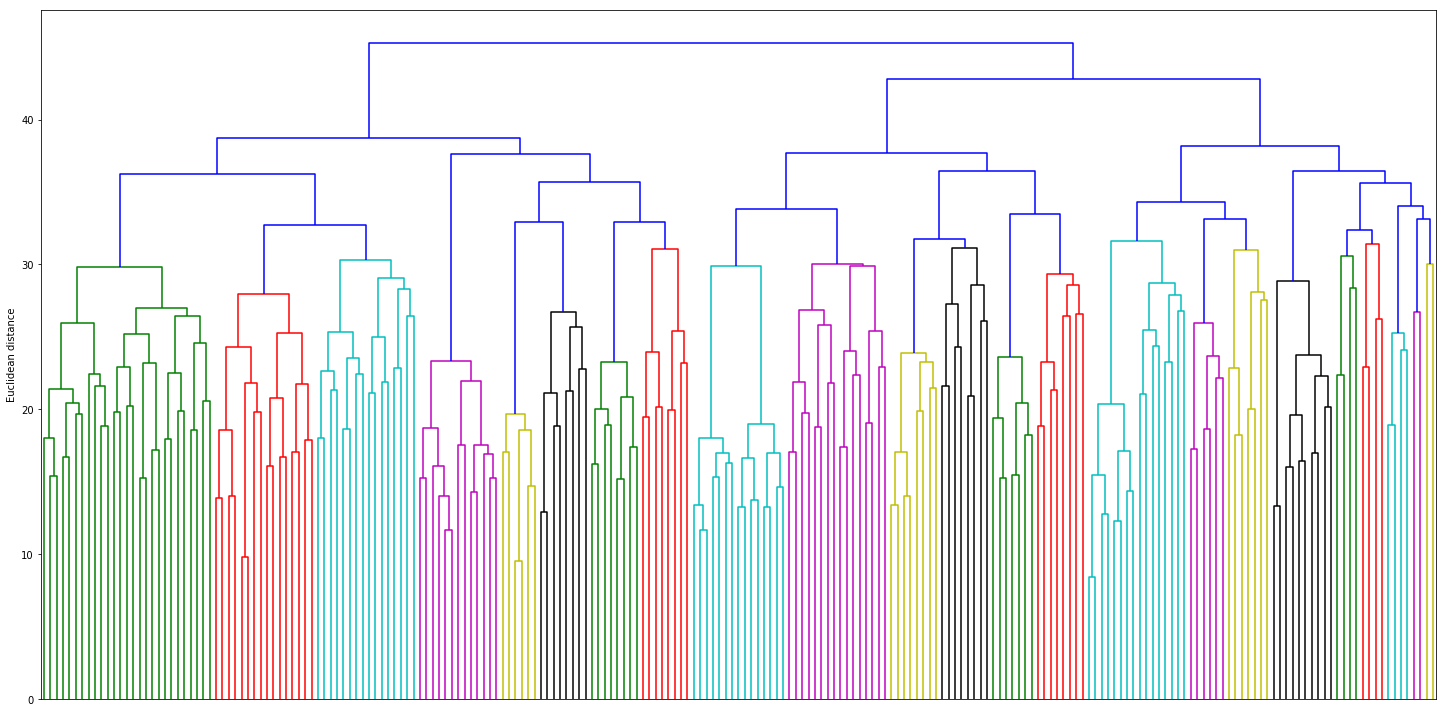

In [78]:
plt.figure(figsize=(20, 10))
row_dendr = dendrogram(row_clusters, 
                       p=7, 
                       truncate_mode='level', 
                       no_labels=True,
                       show_leaf_counts=True,  # otherwise numbers in brackets are counts
#                        leaf_rotation=90.,
#                        leaf_font_size=12.,
#                        show_contracted=True,  # to get a distribution impression in truncated branches
                      )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

Możemy wyrysować po 10 elementów z każdej grupy.

C:\Users\przem\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


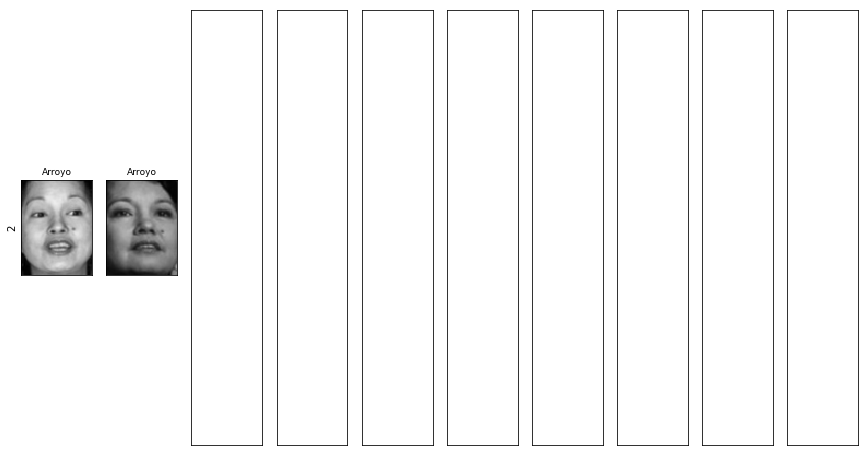

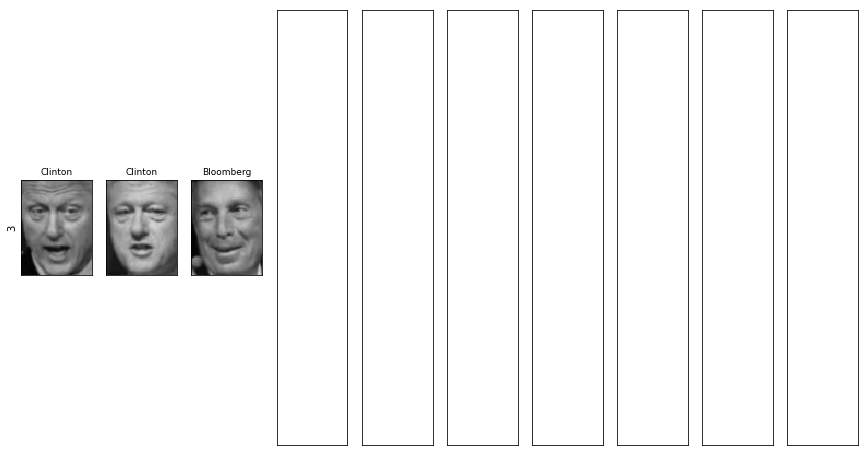

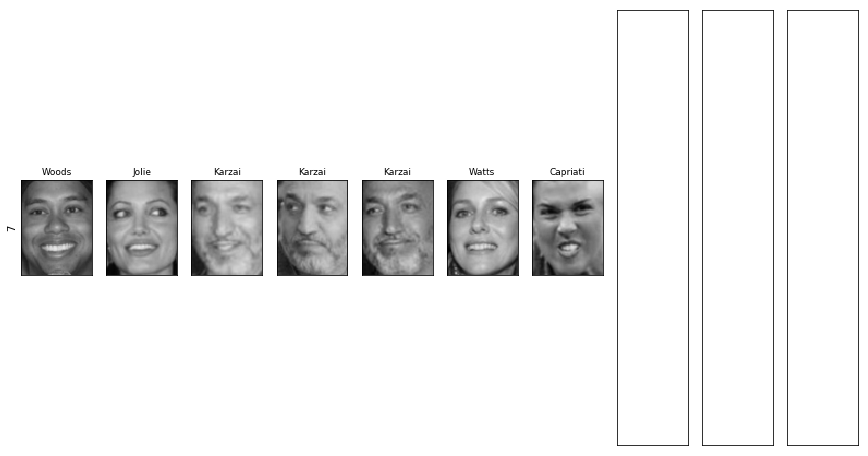

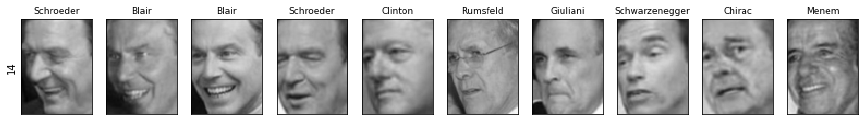

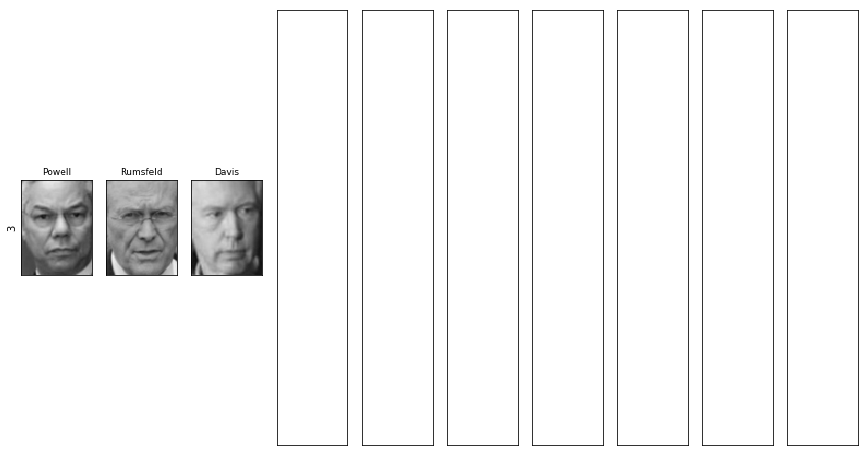

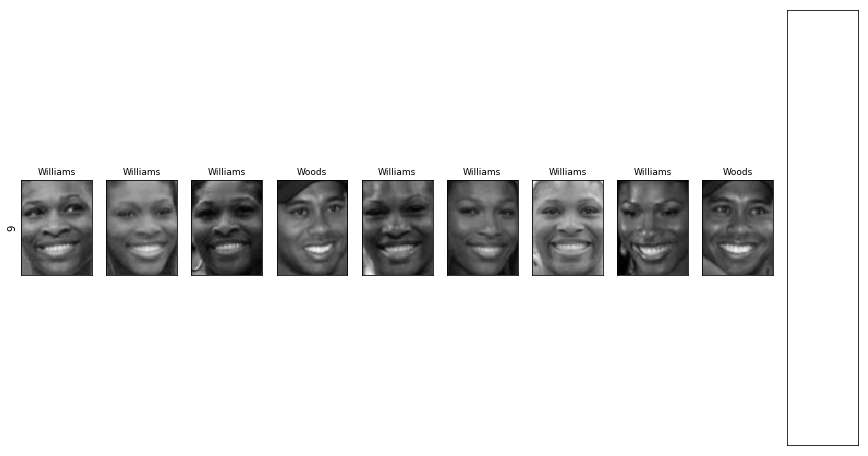

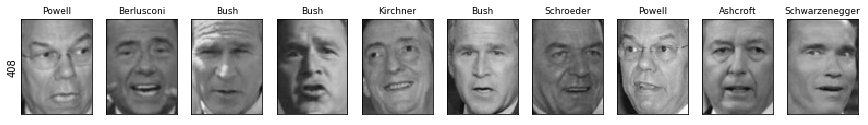

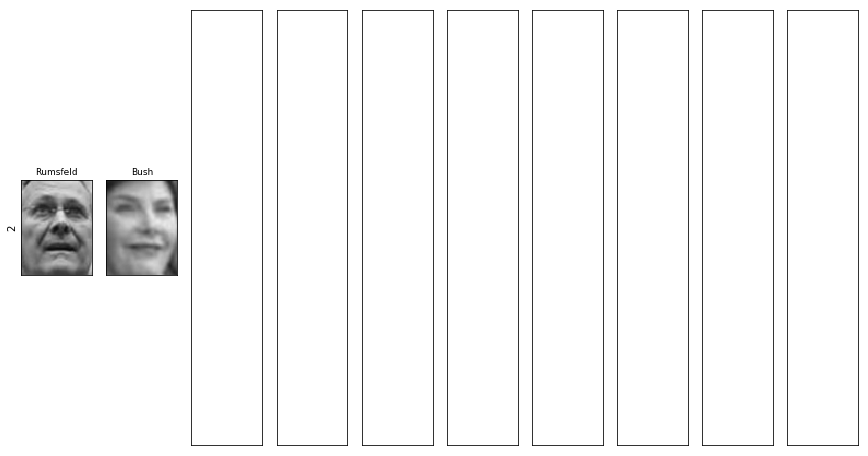

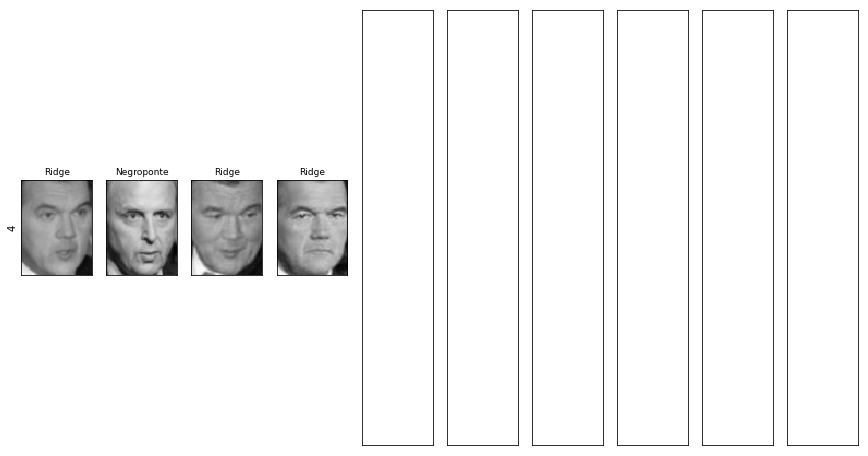

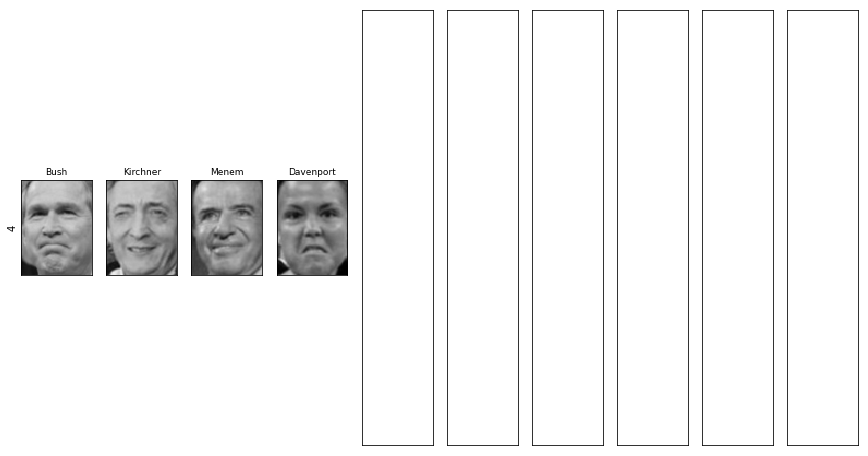

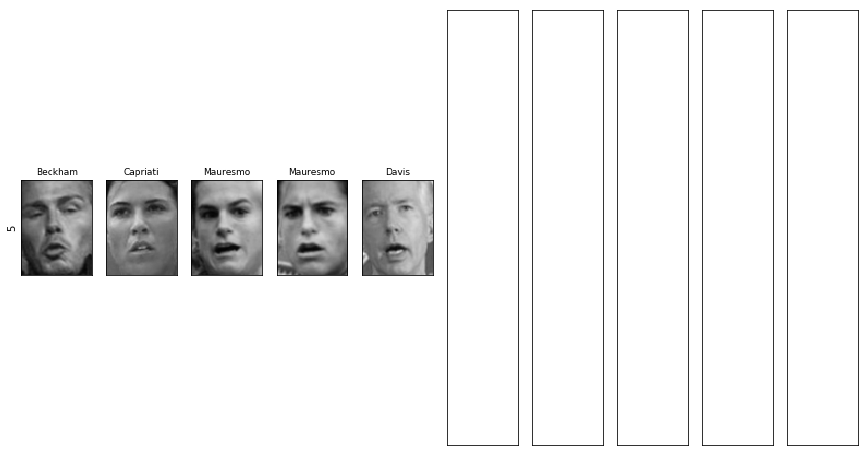

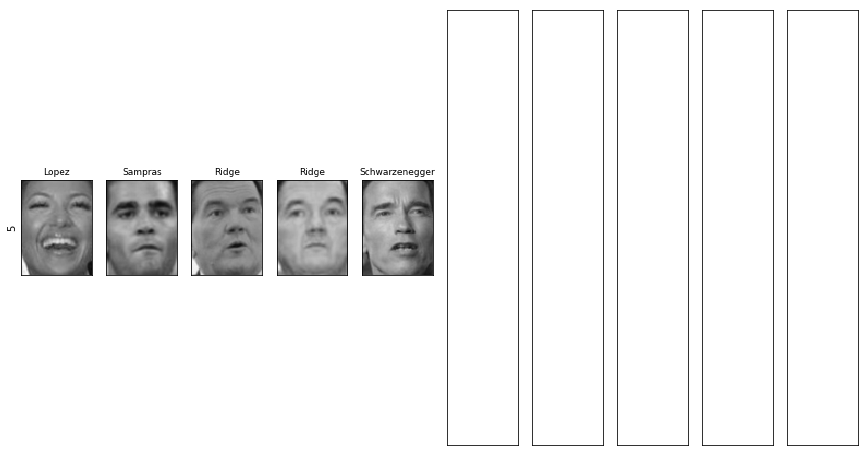

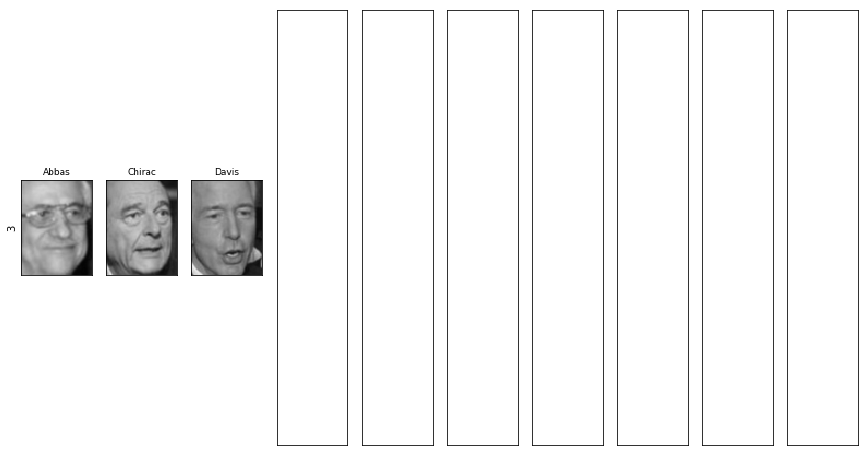

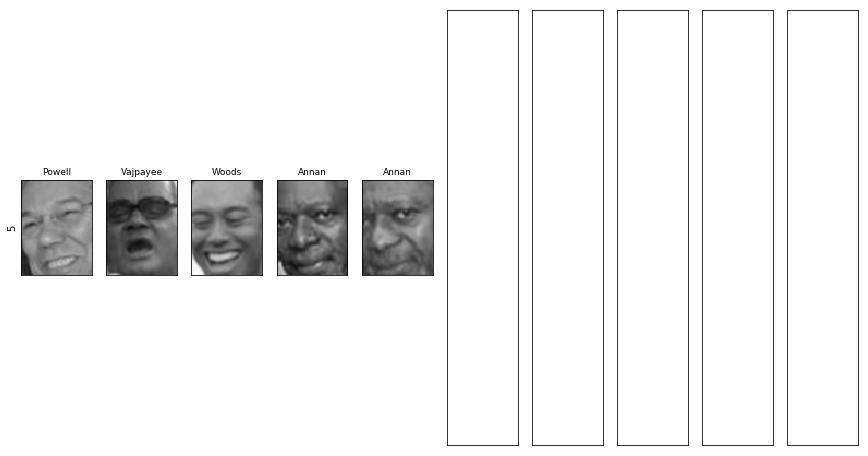

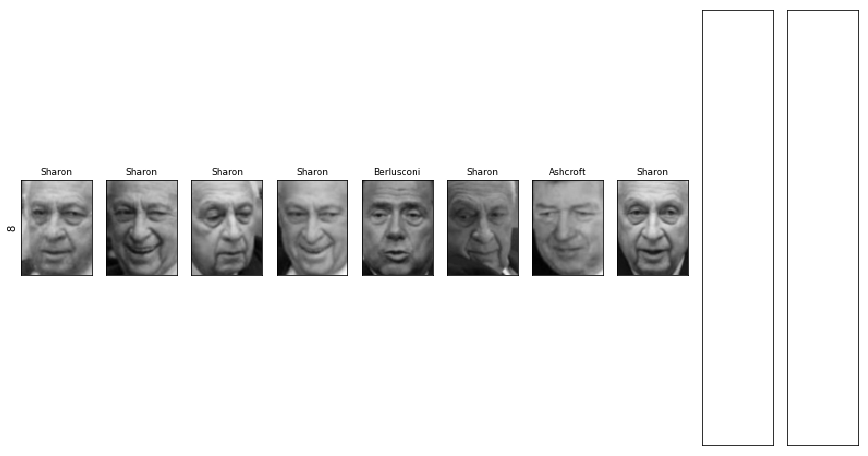

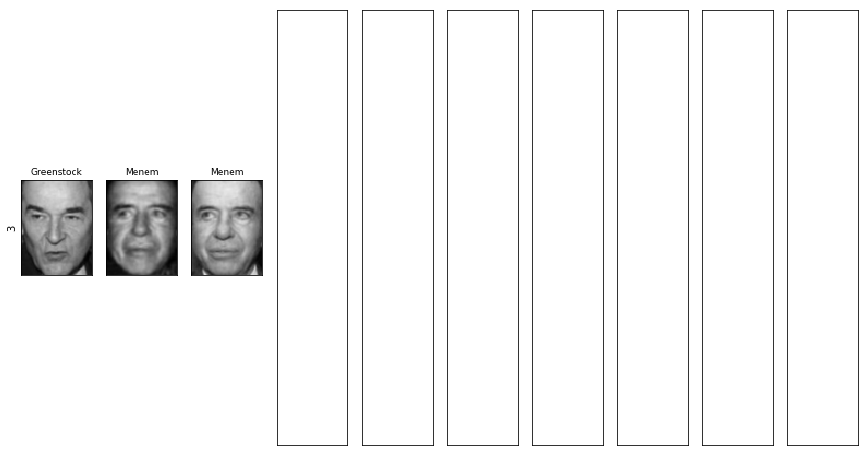

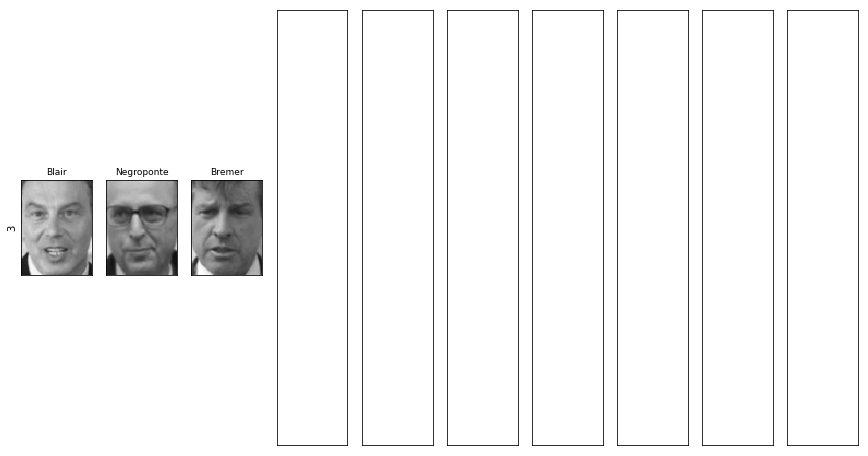

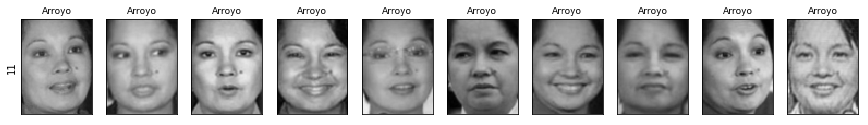

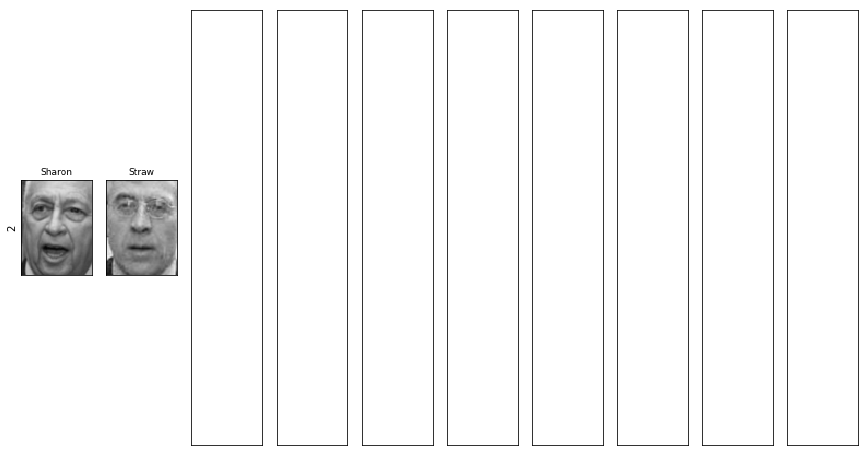

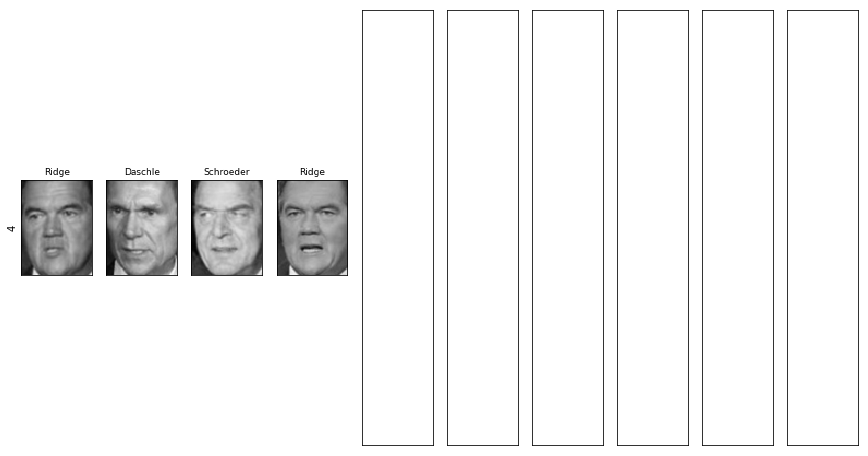

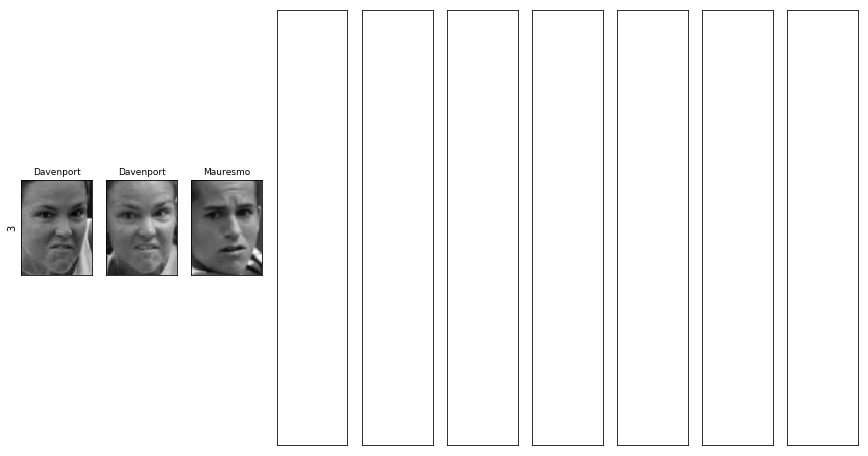

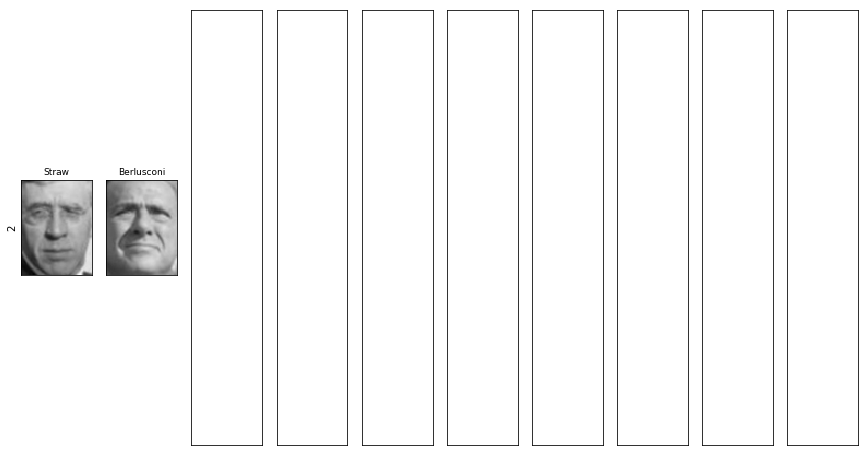

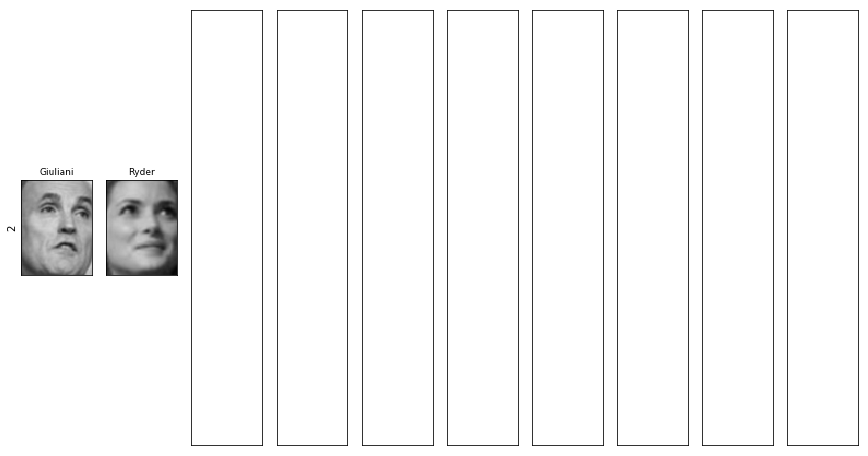

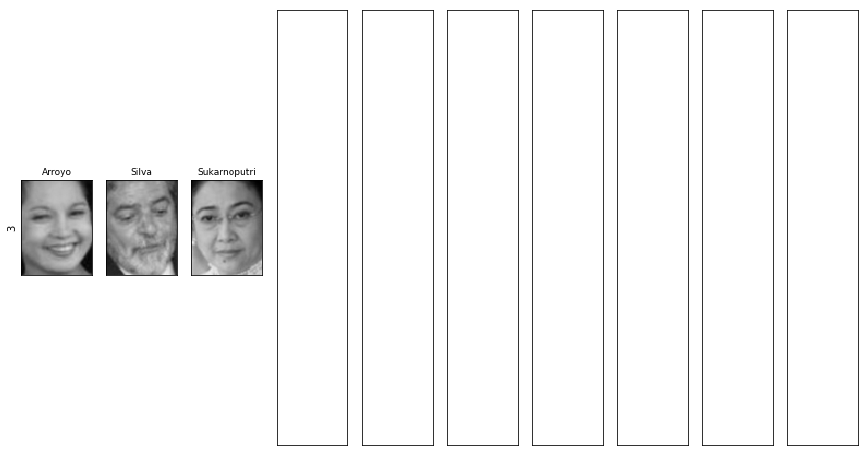

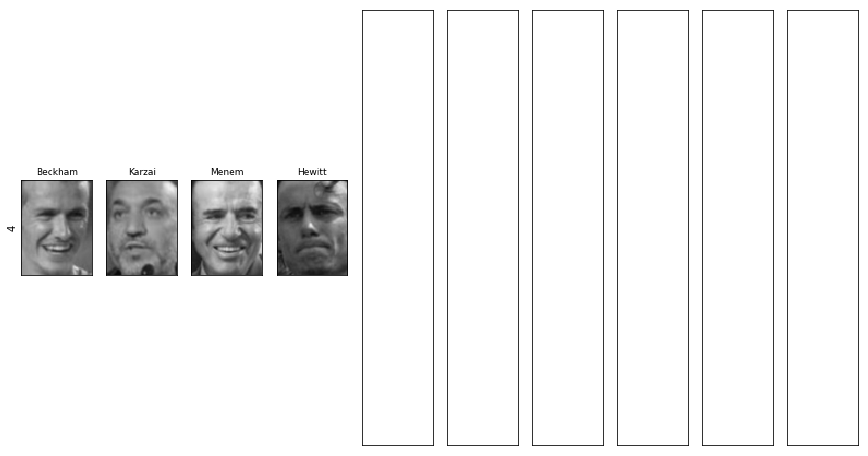

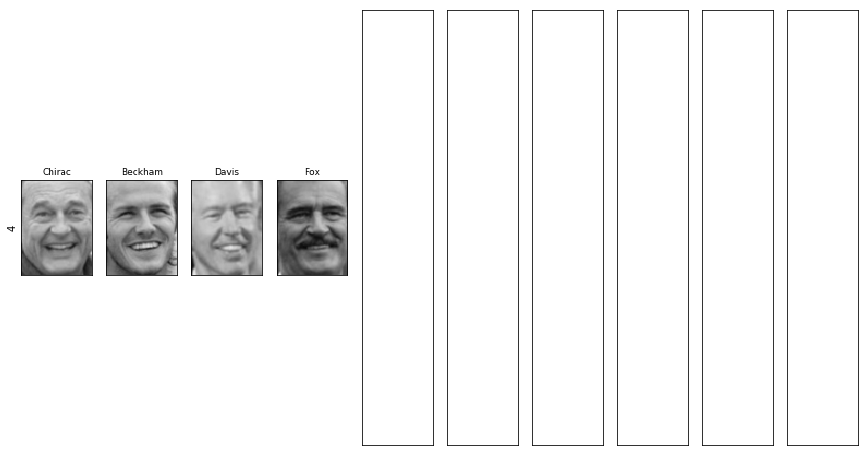

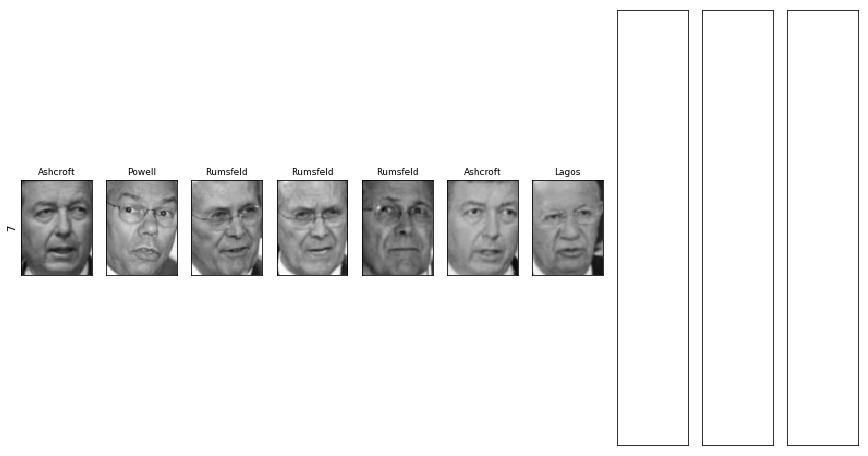

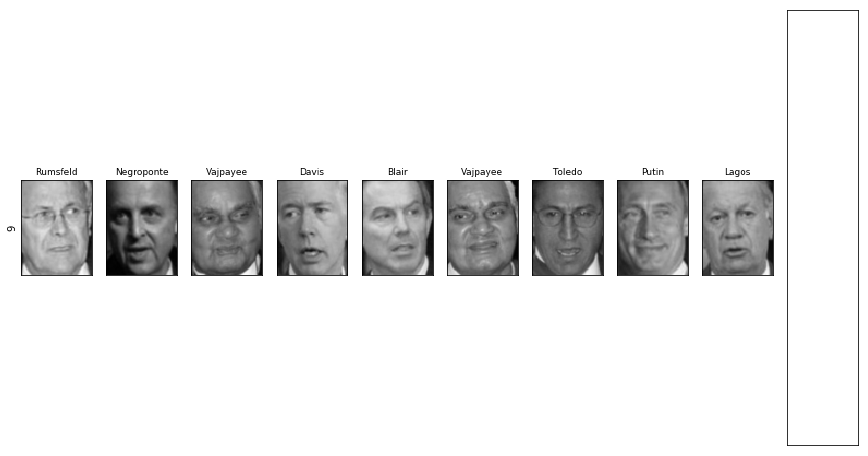

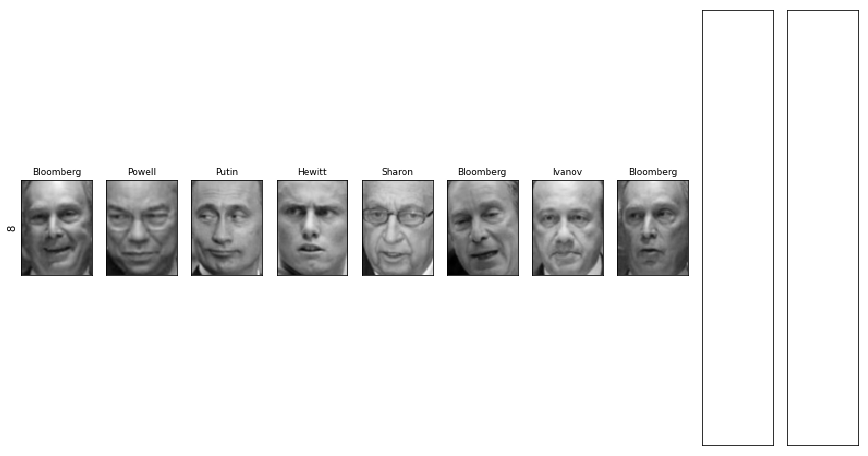

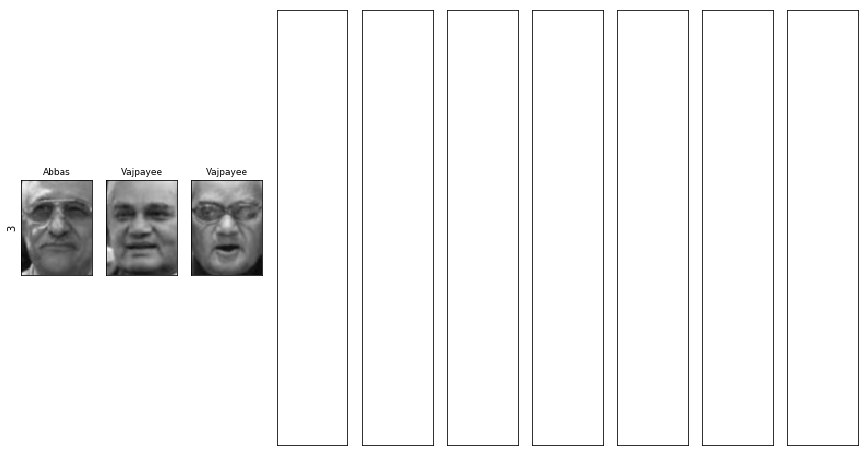

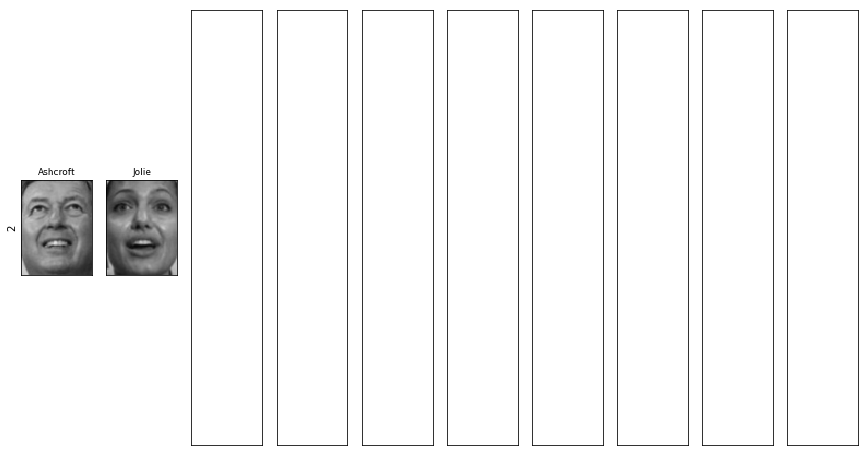

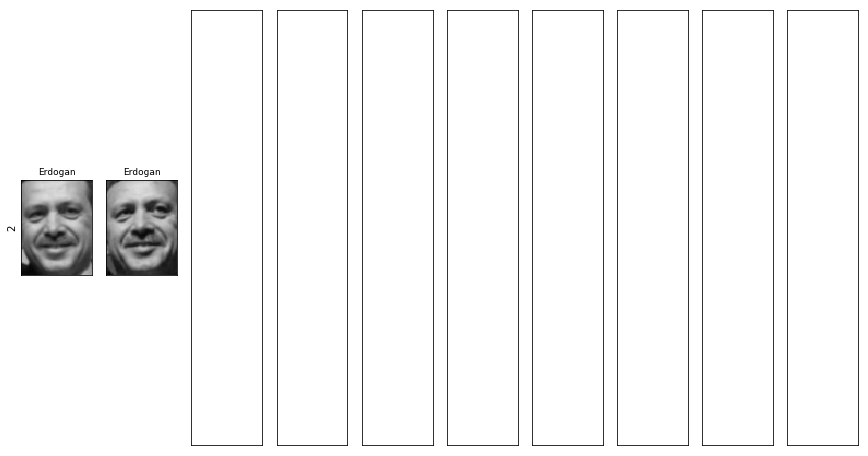

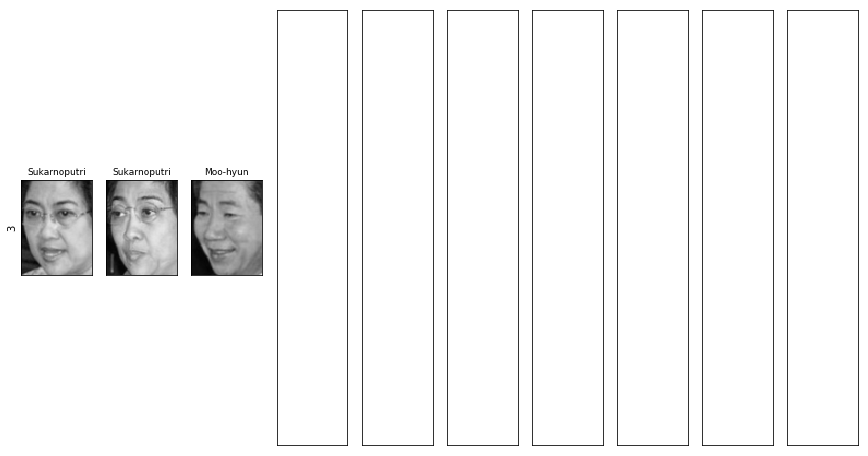

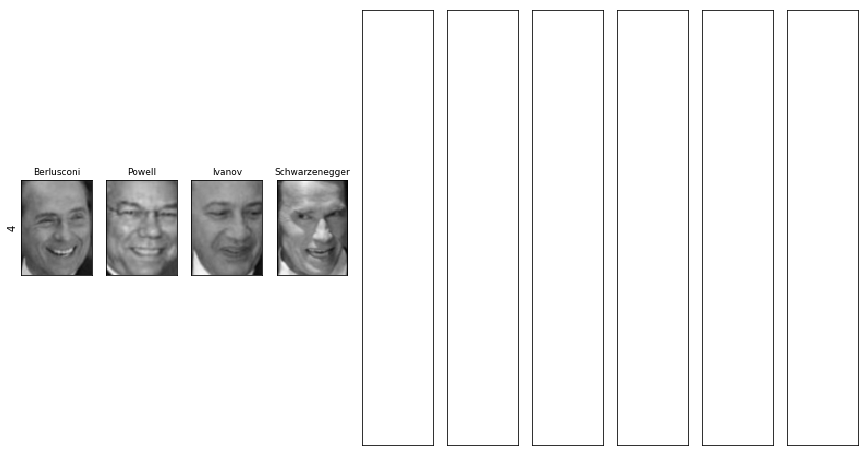

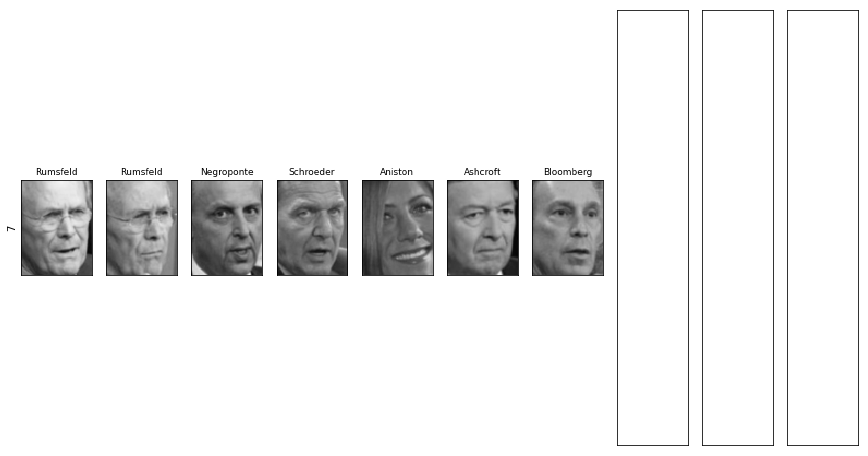

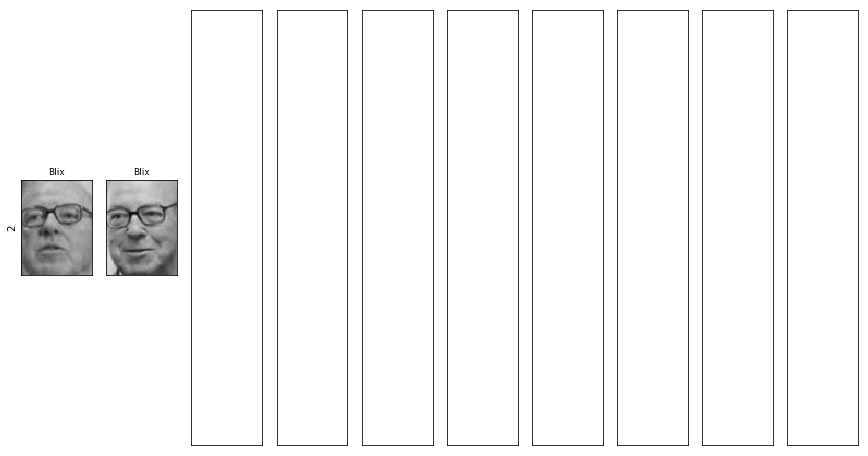

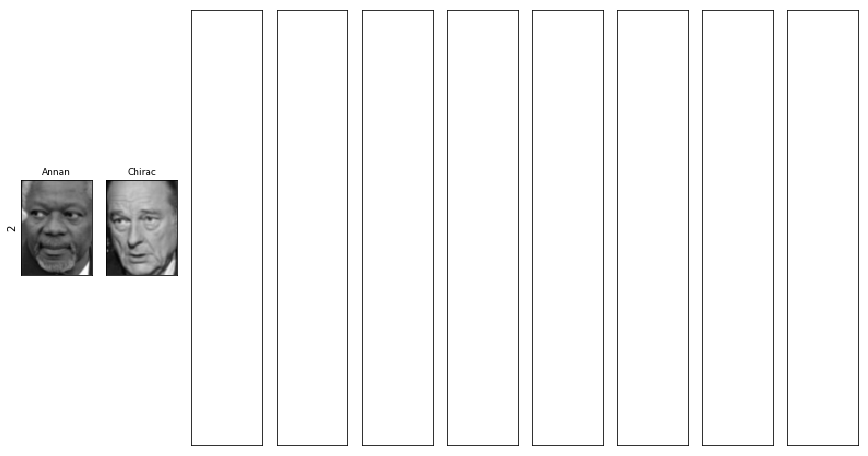

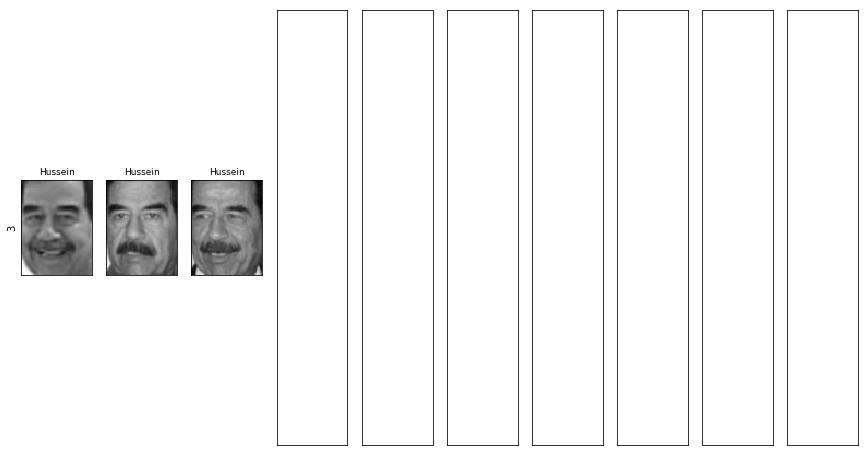

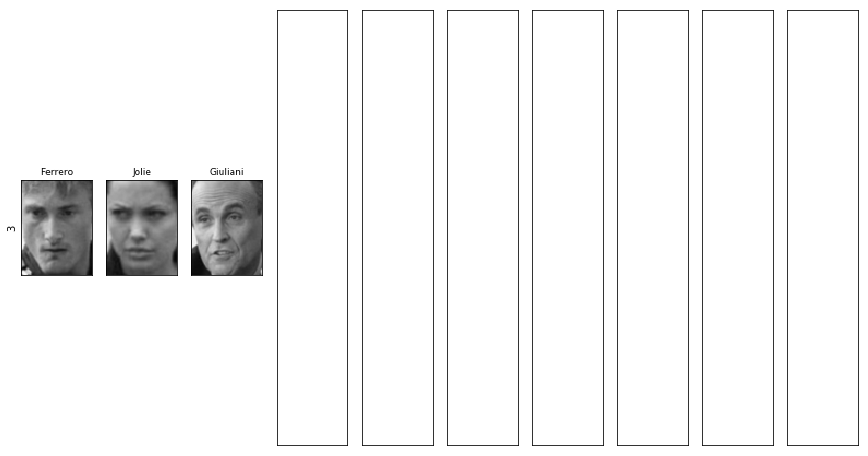

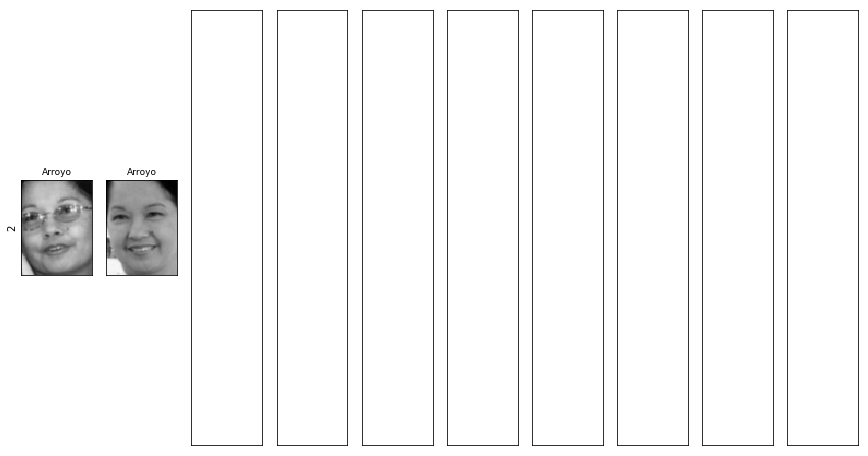

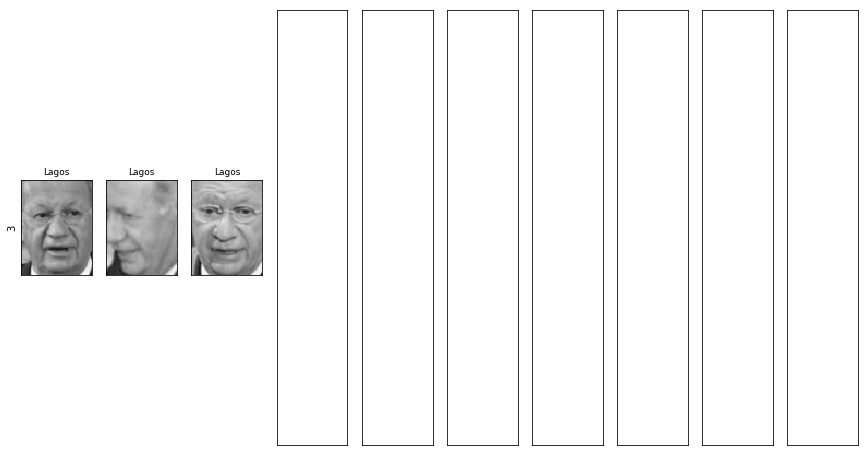

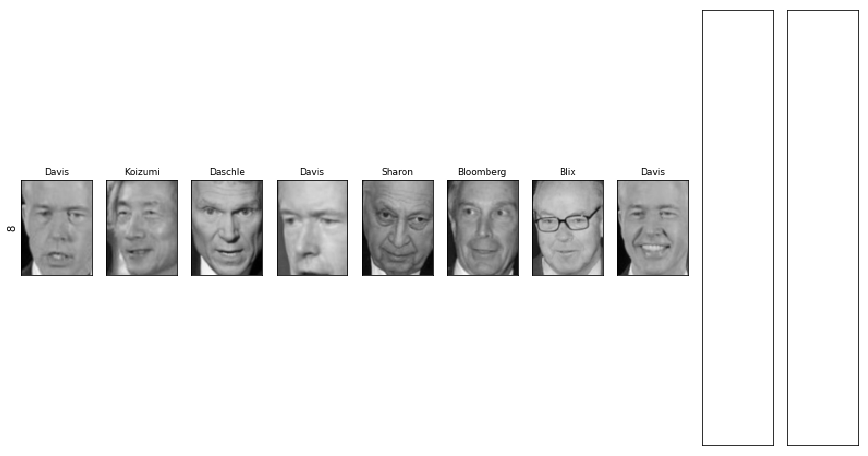

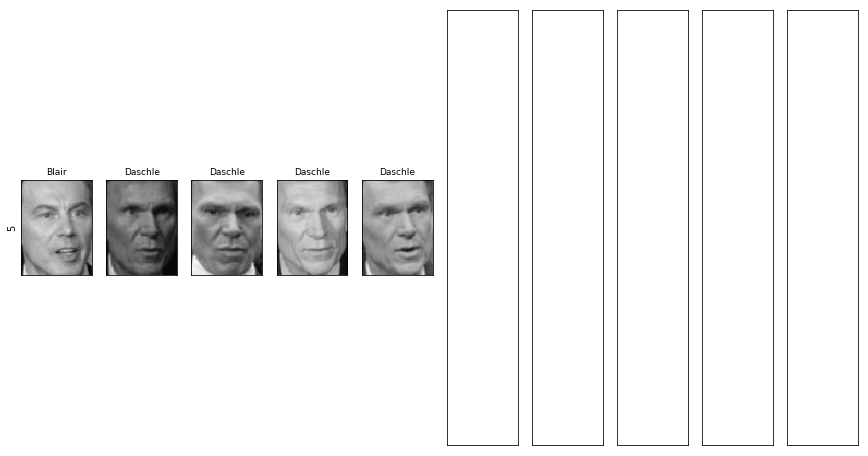

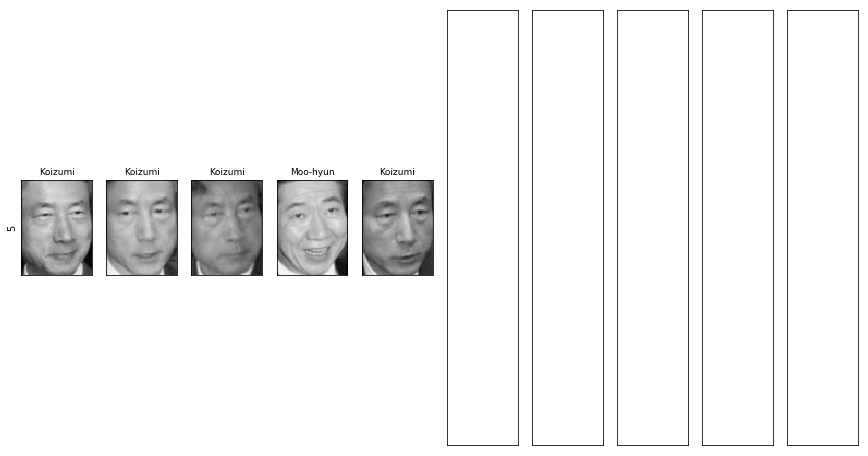

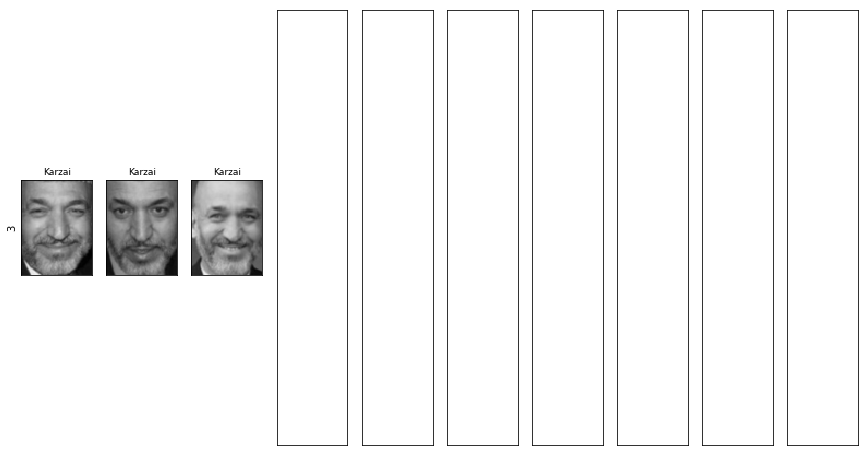

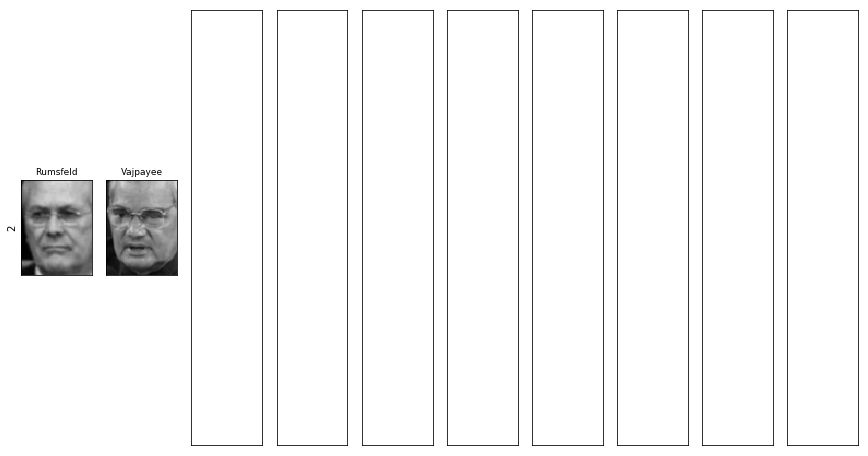

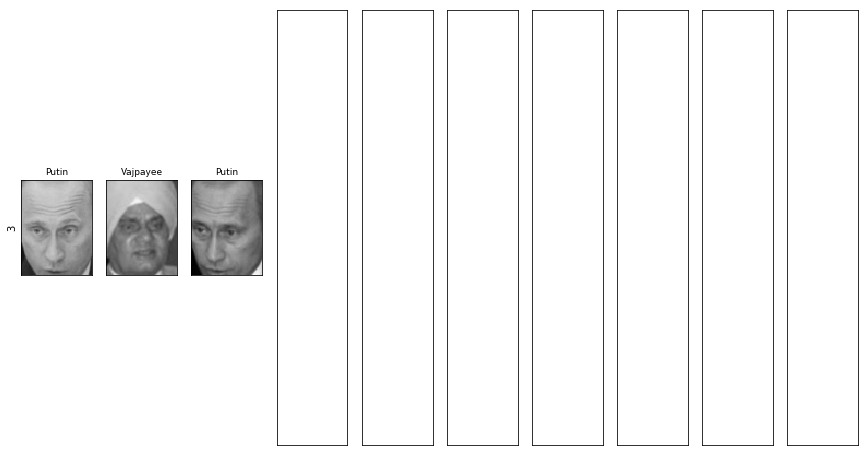

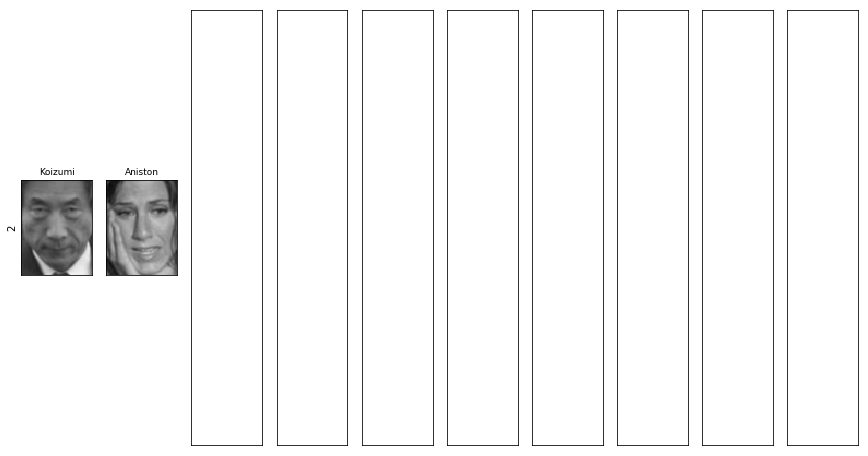

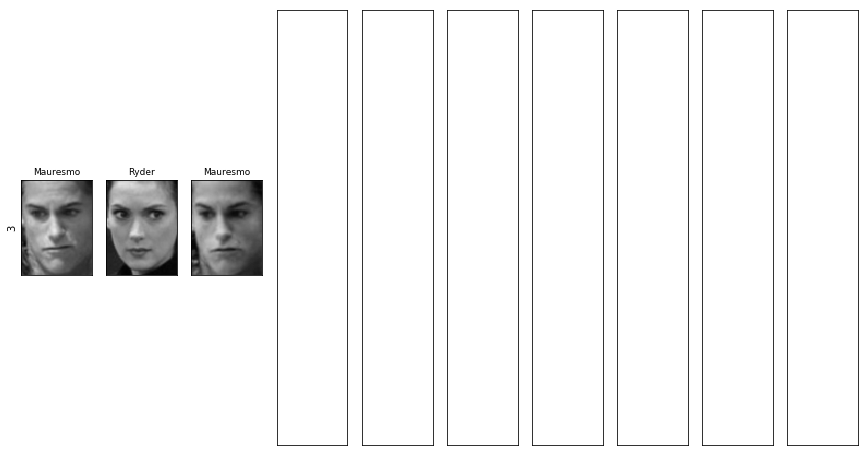

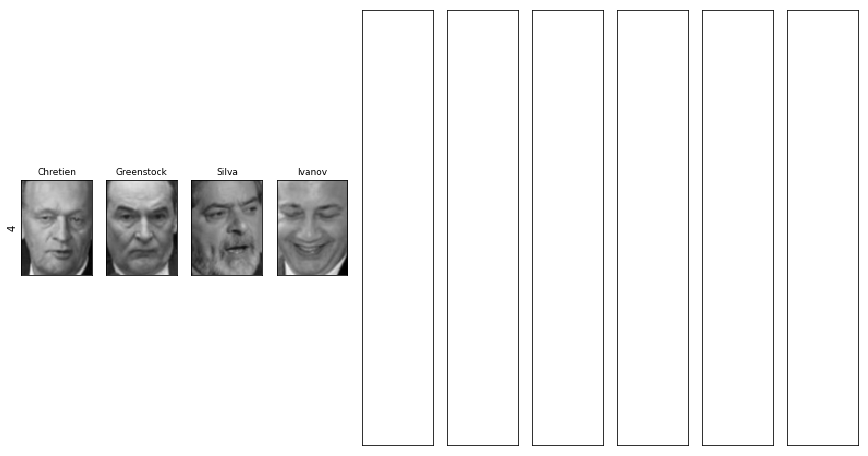

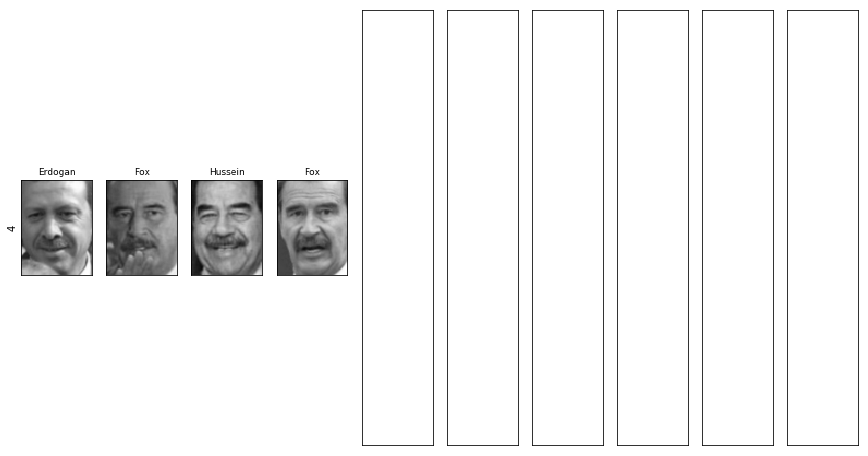

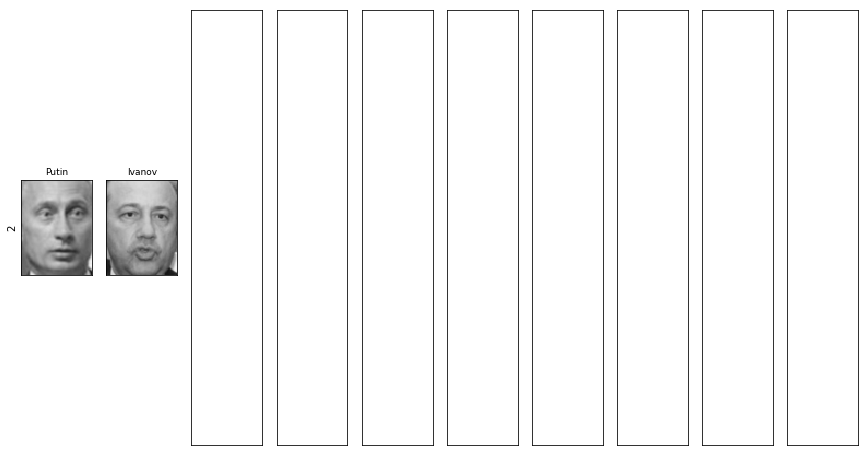

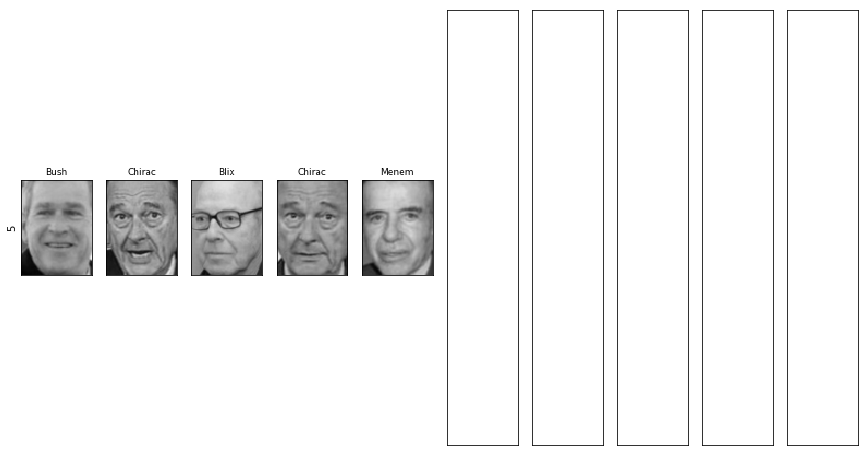

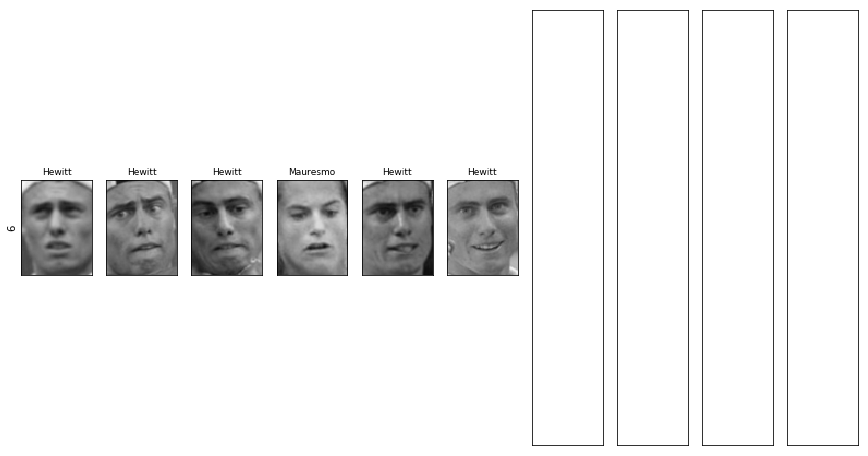

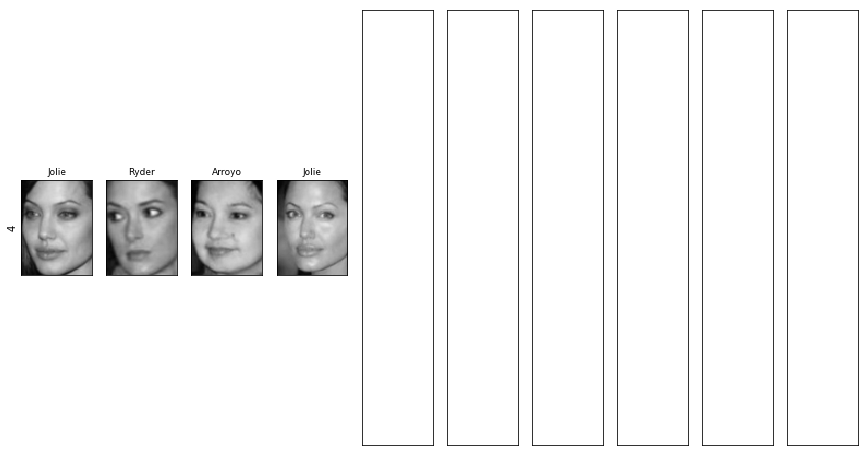

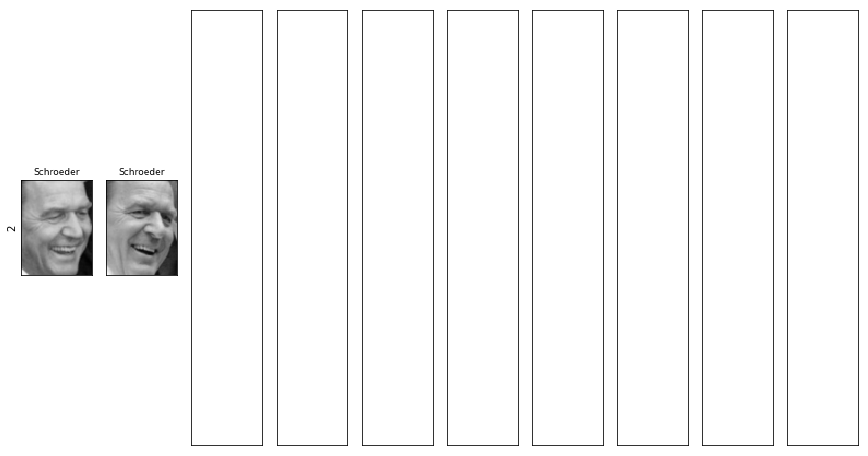

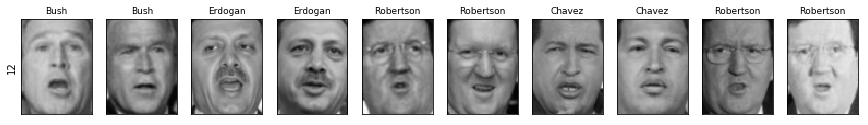

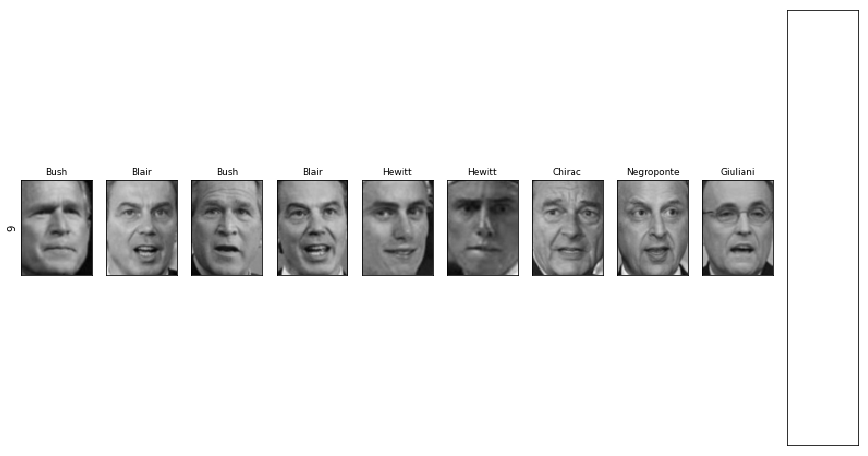

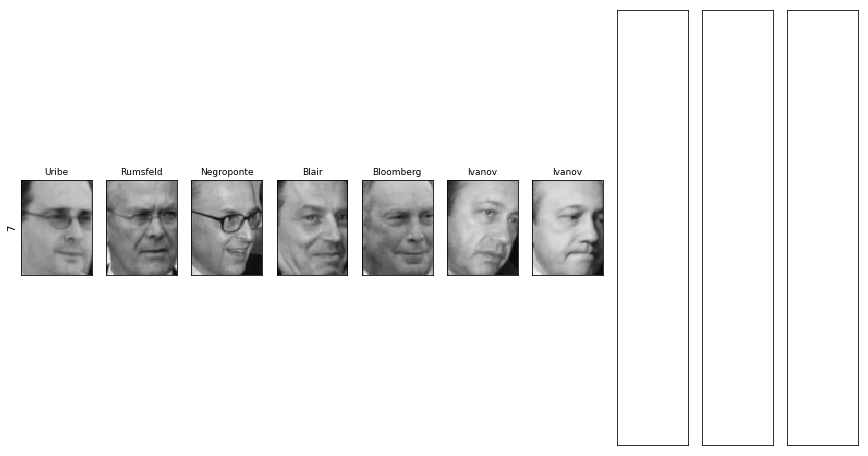

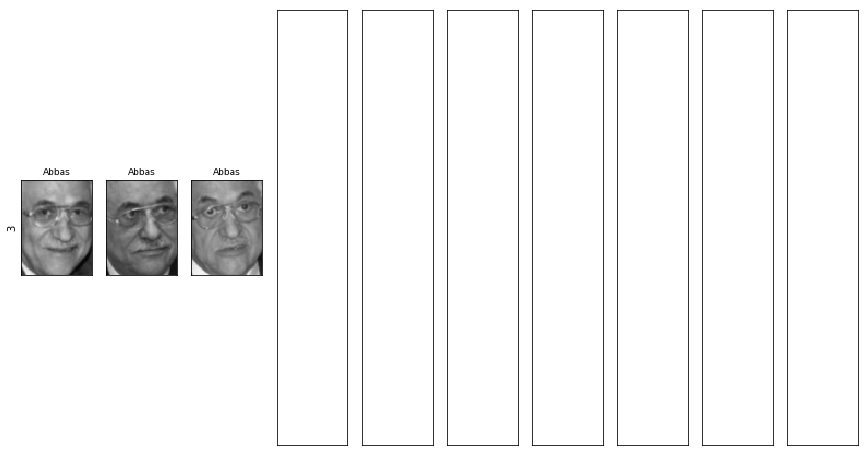

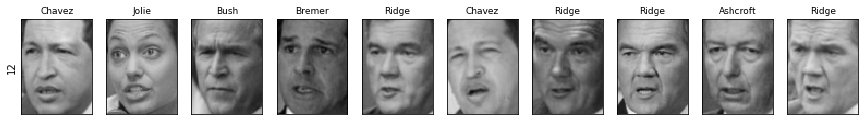

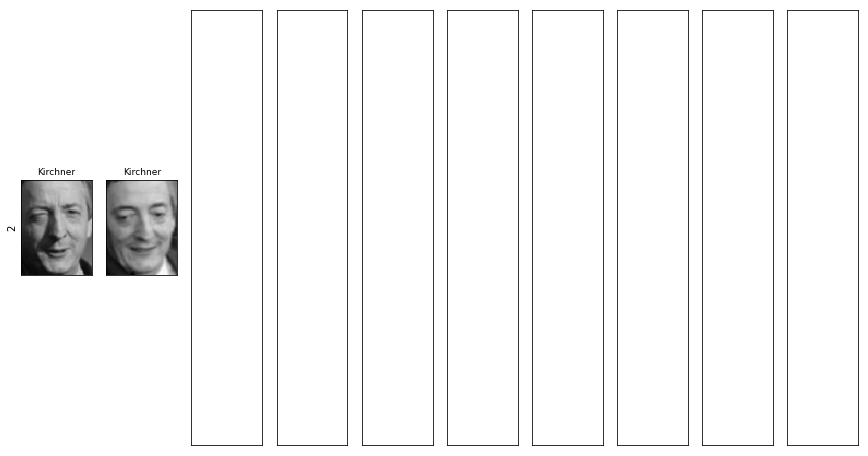

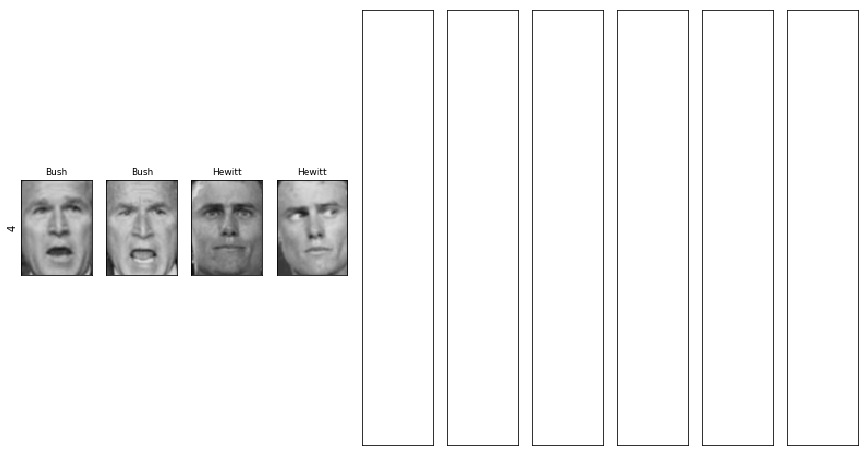

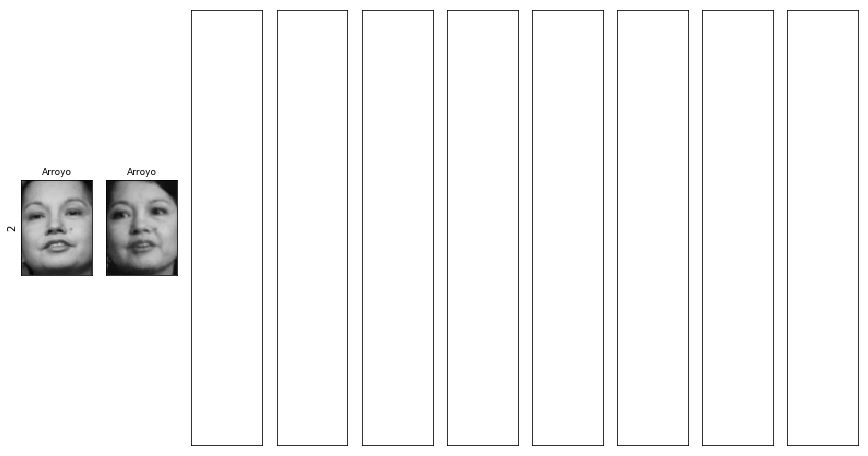

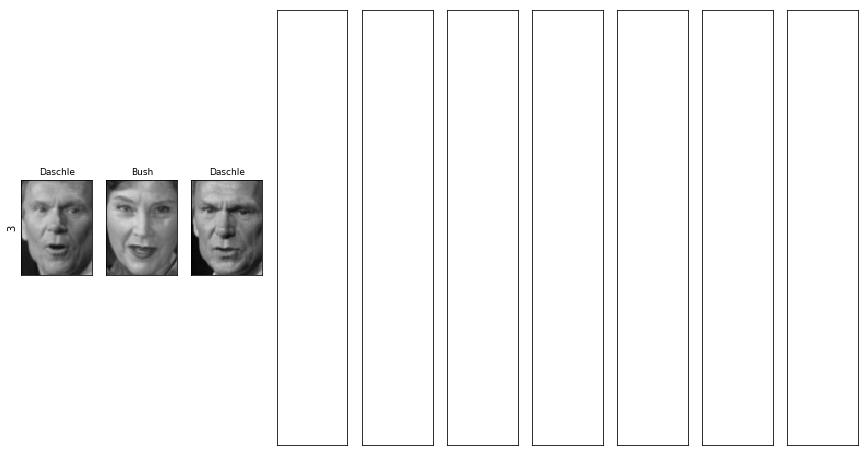

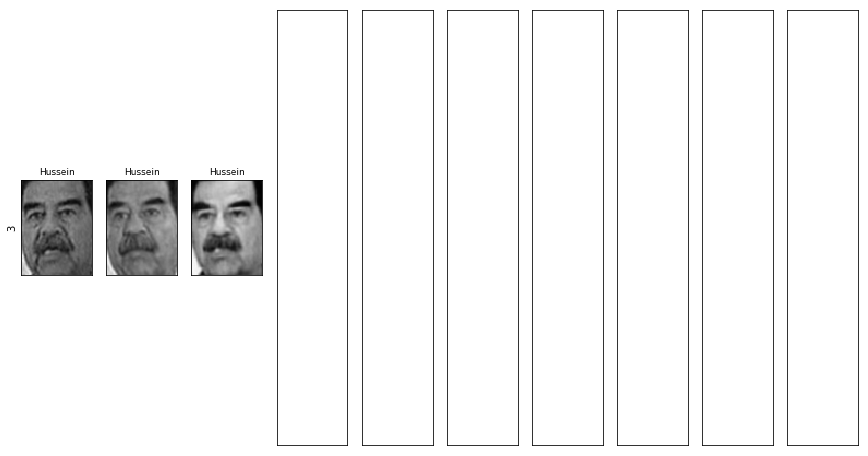

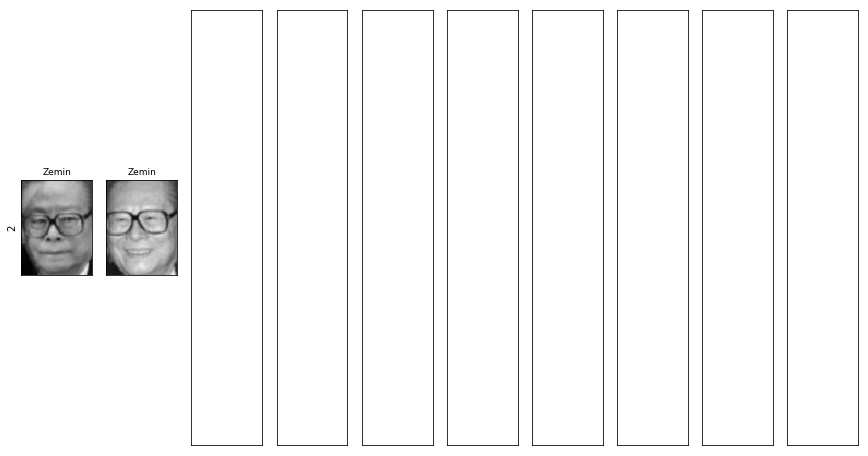

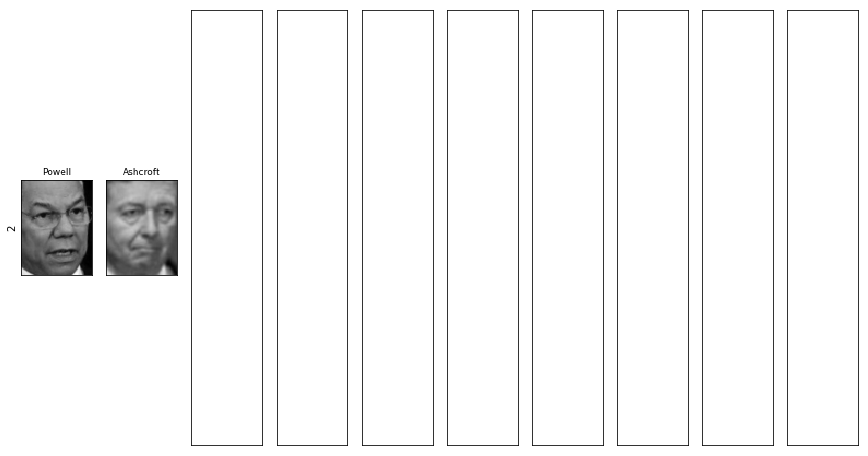

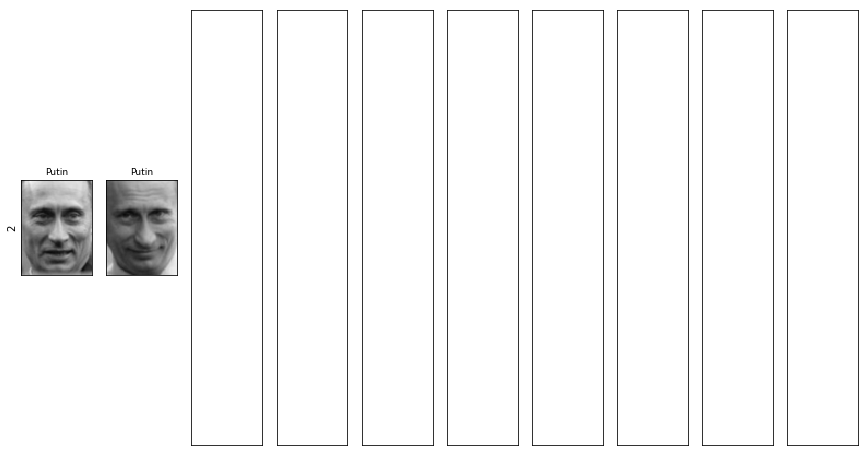

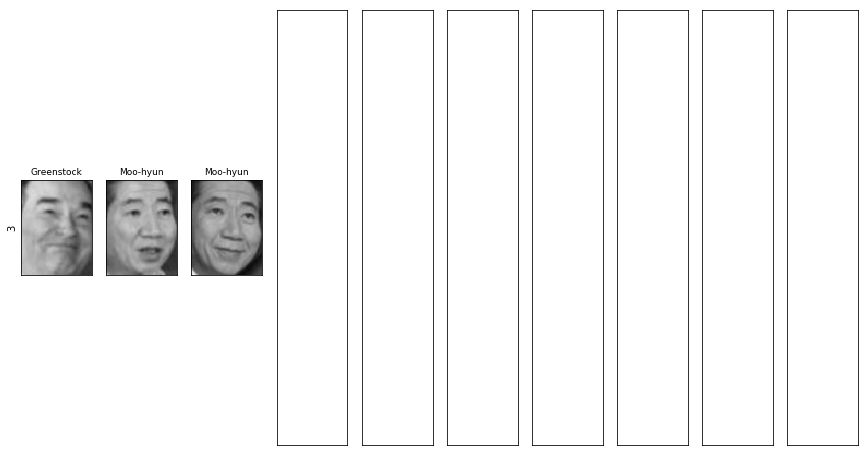

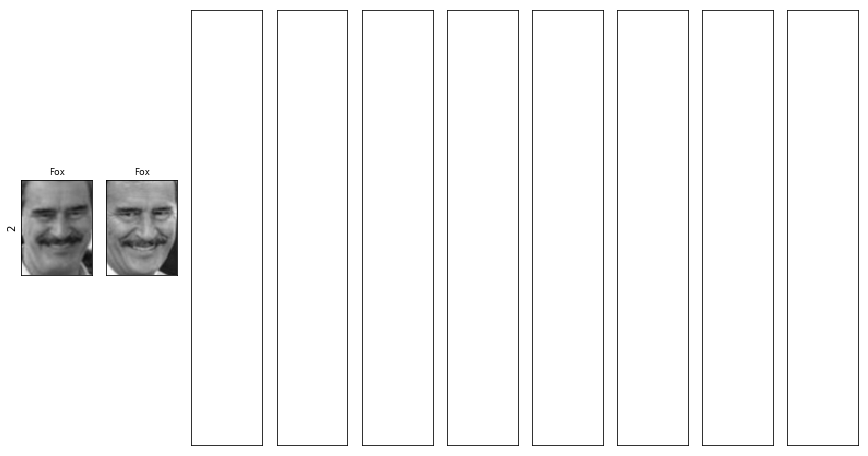

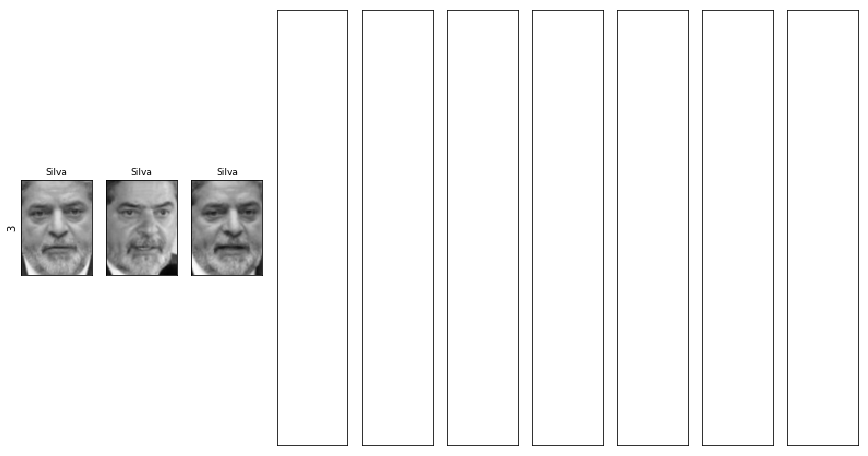

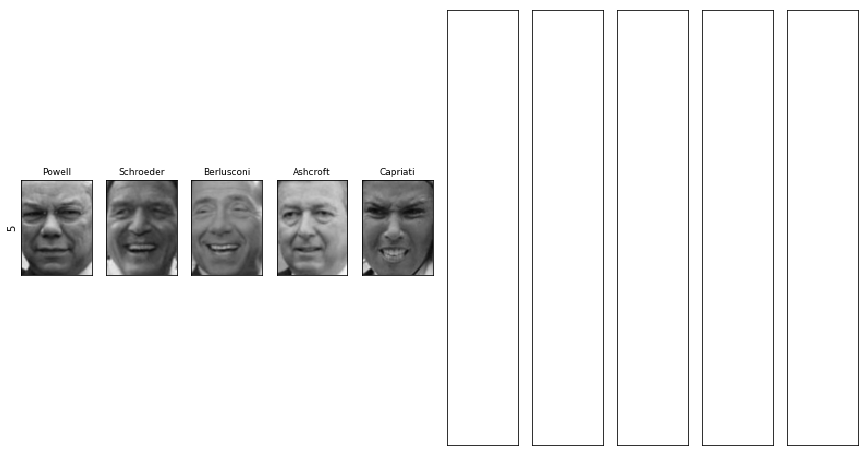

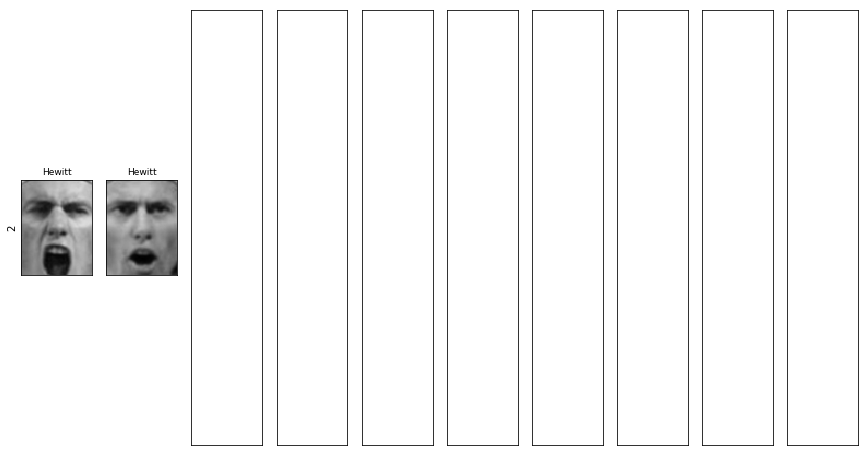

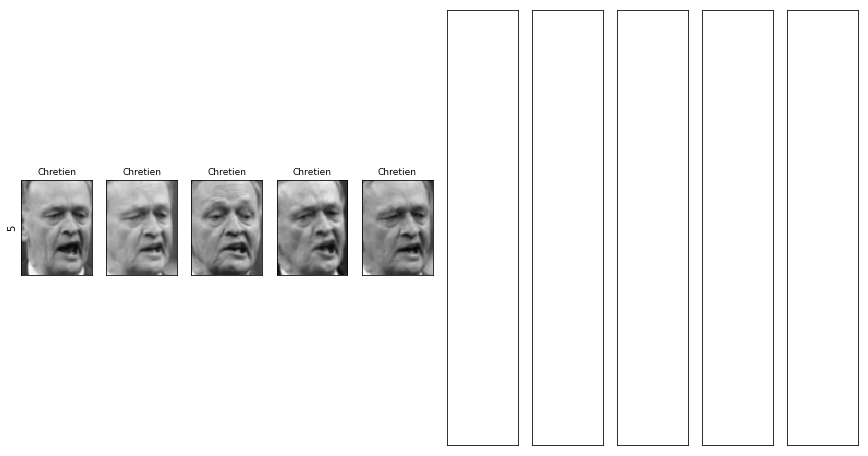

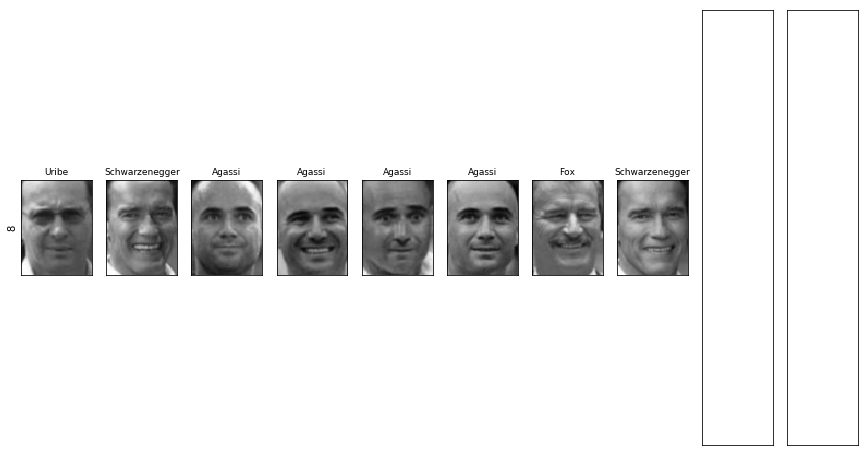

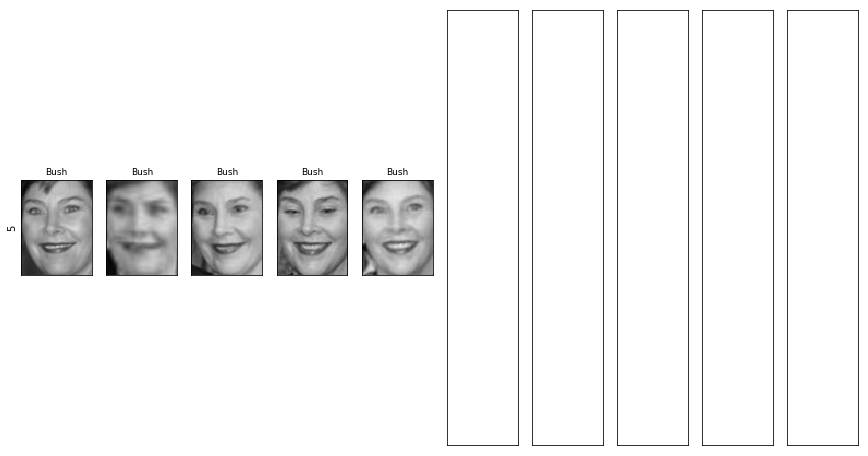

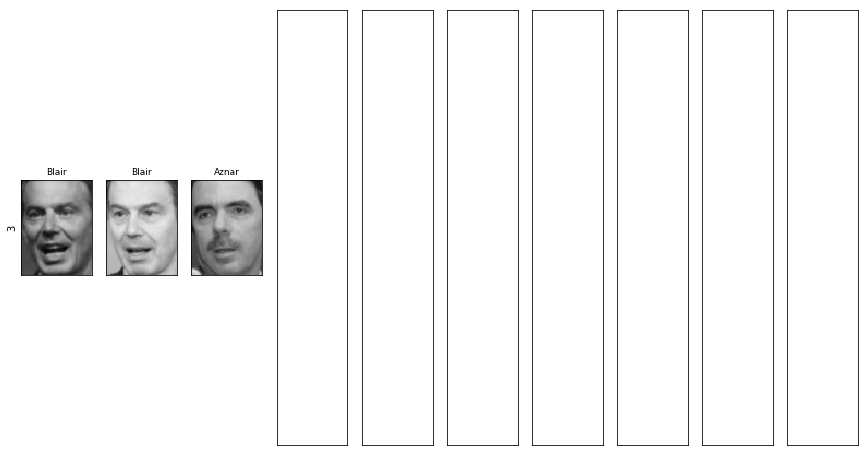

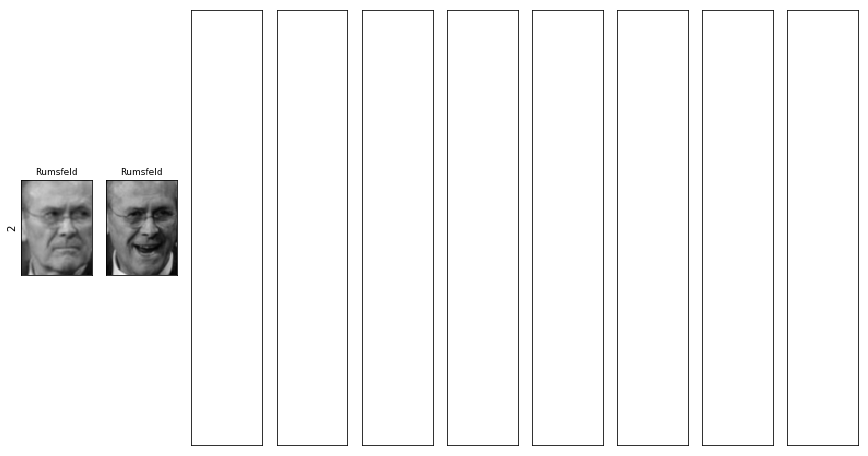

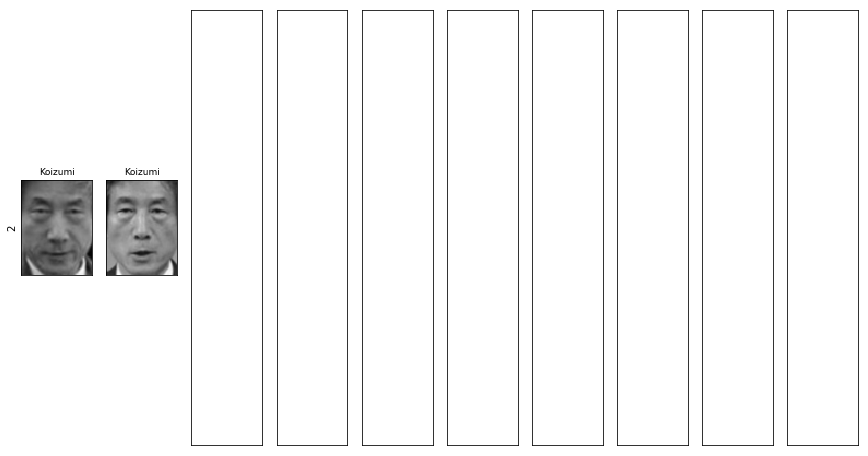

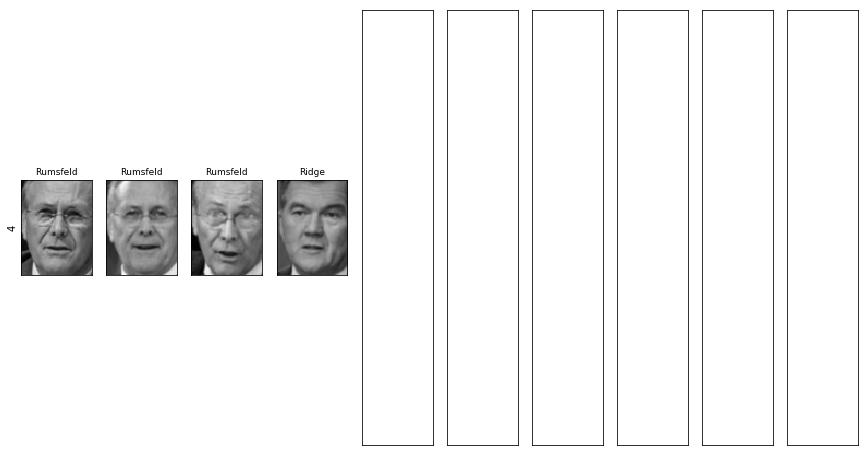

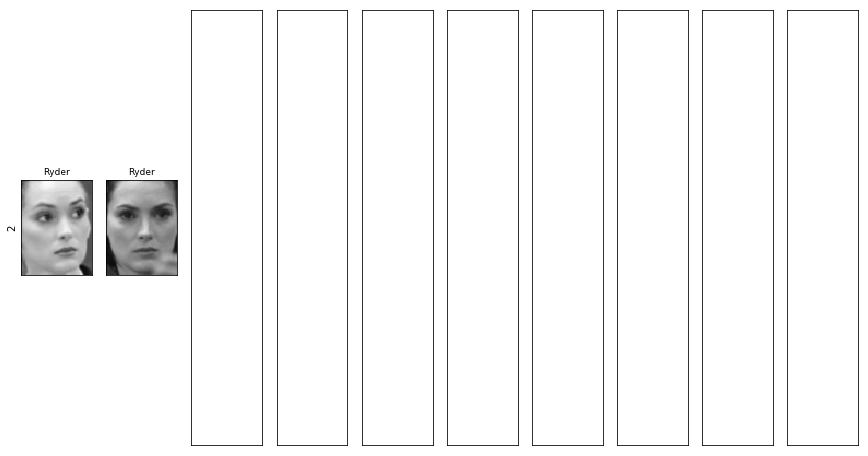

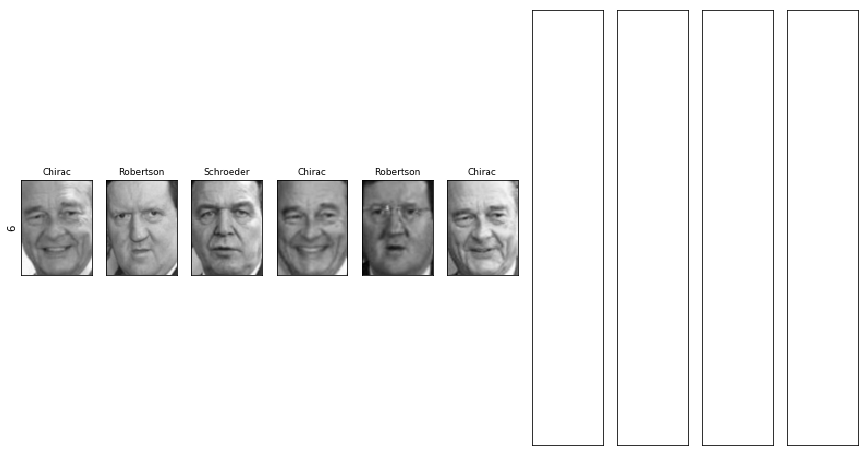

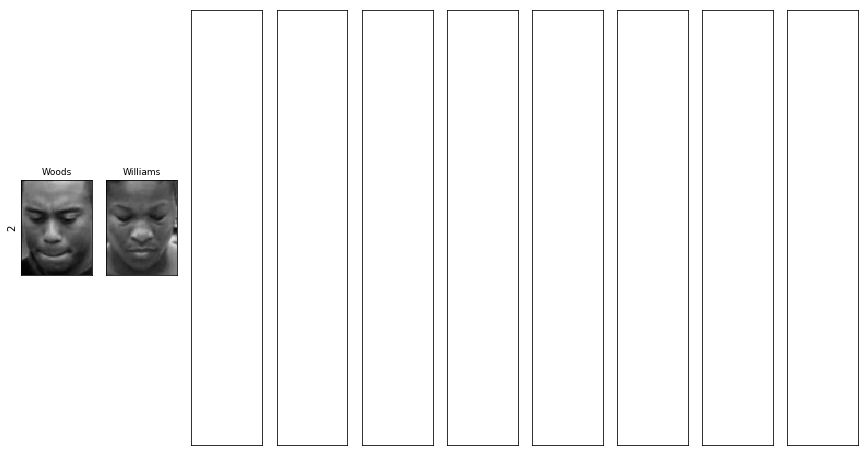

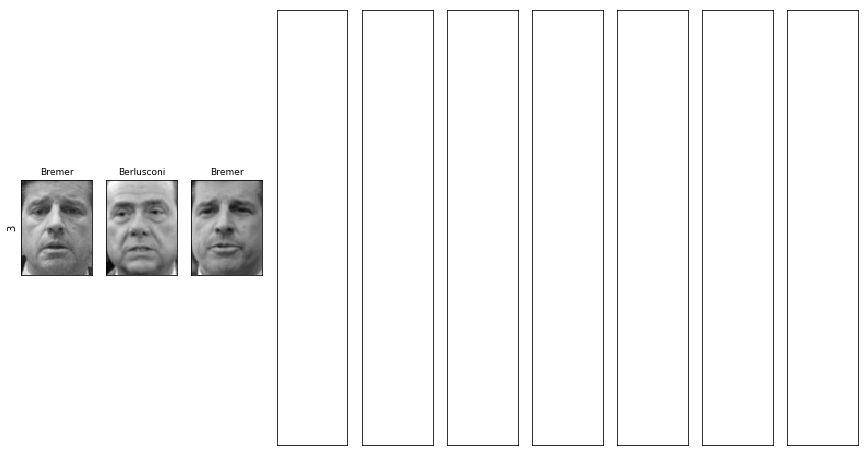

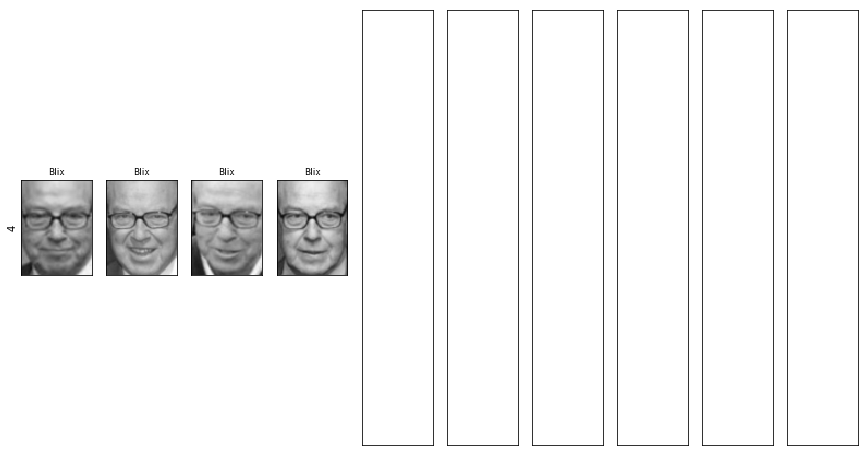

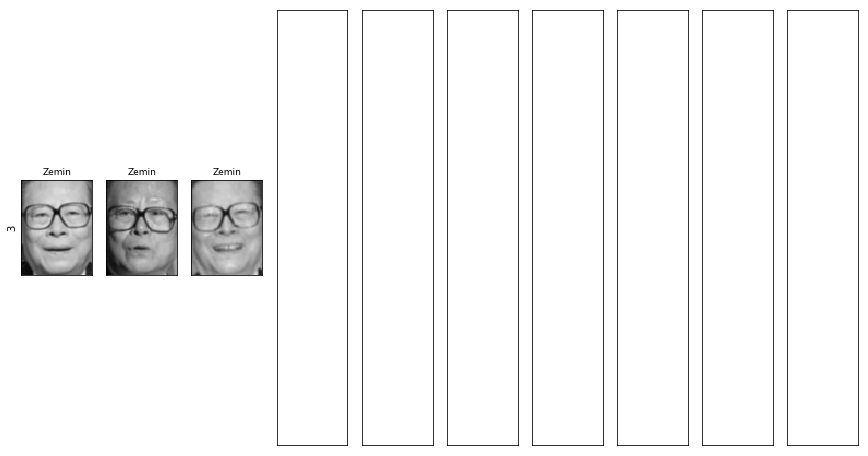

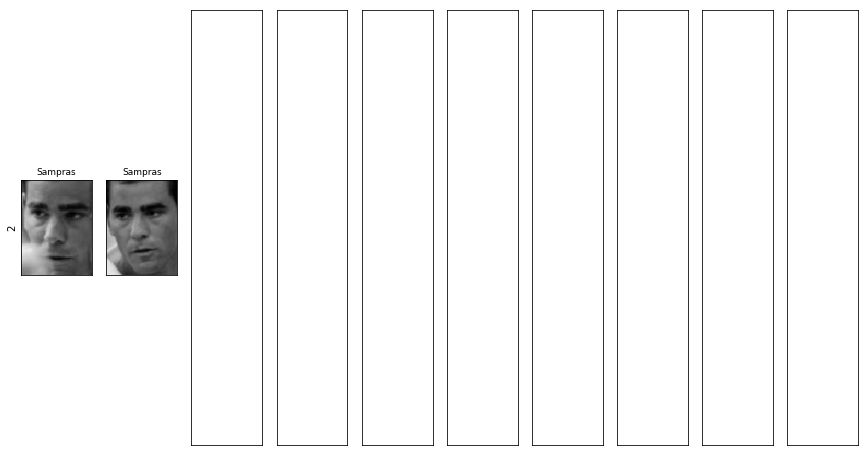

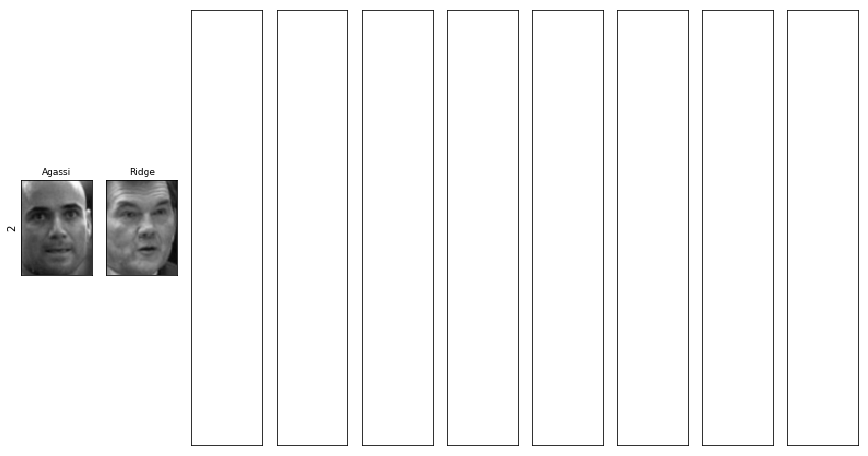

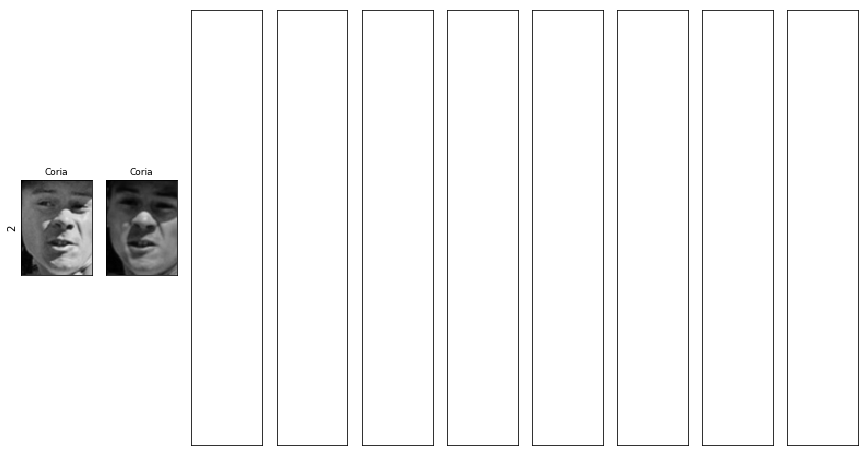

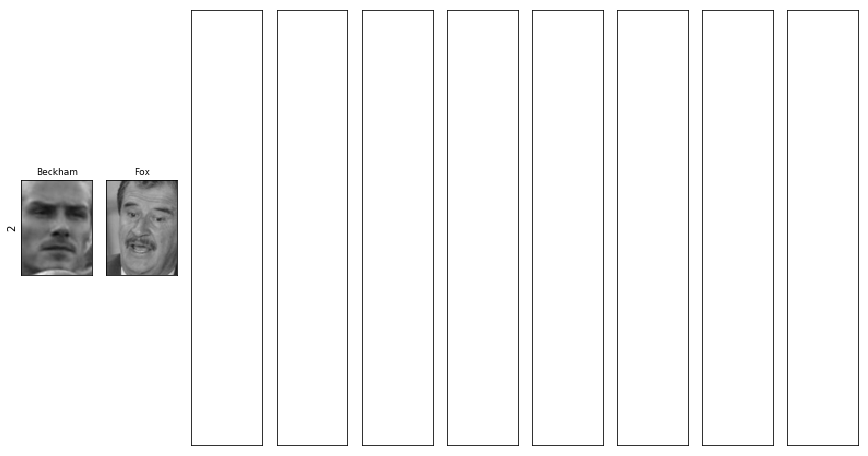

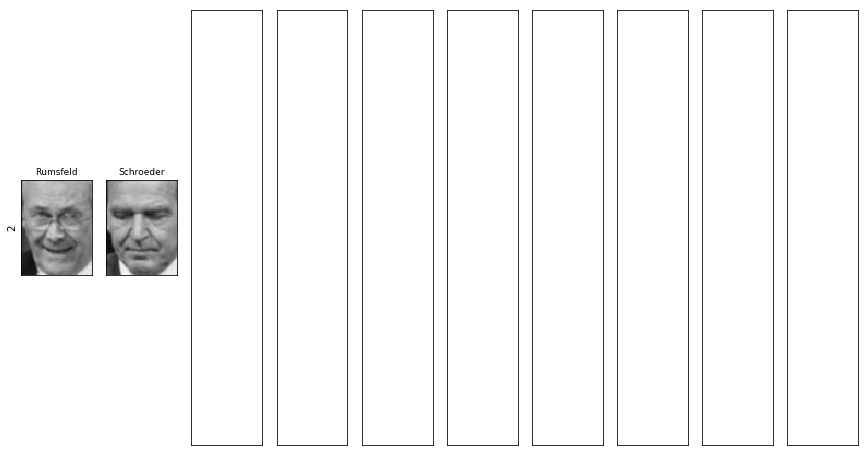

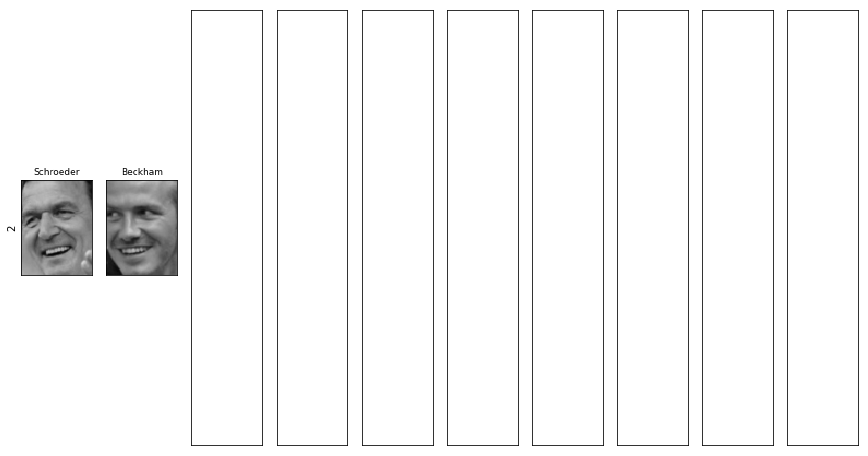

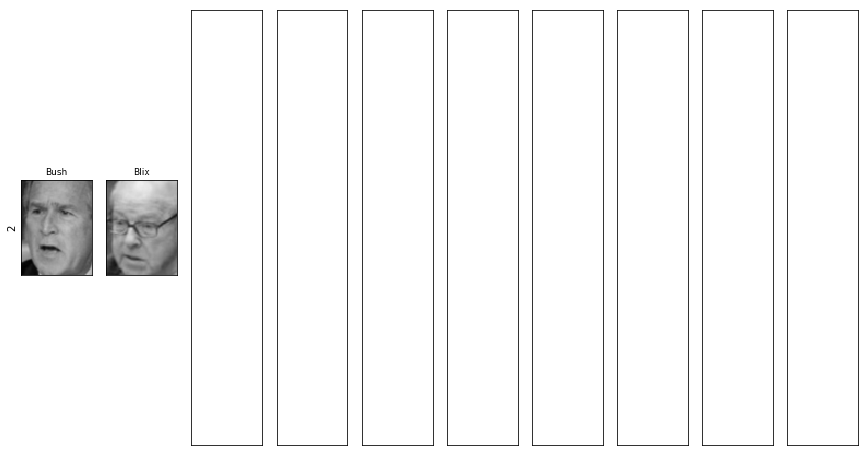

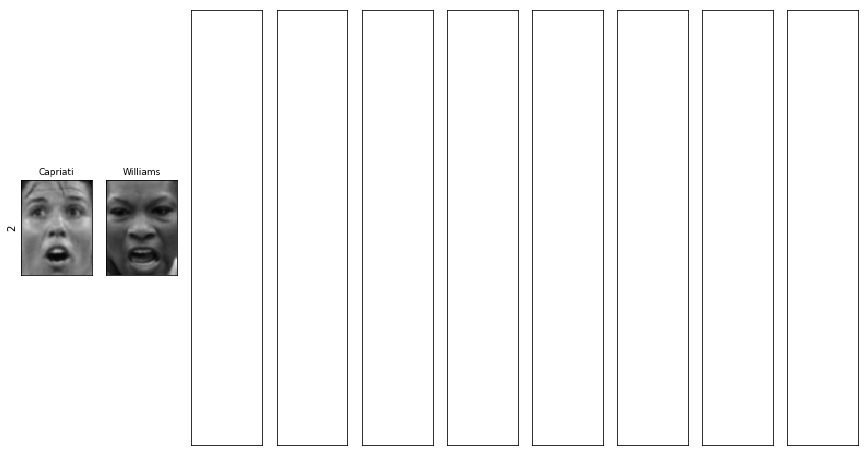

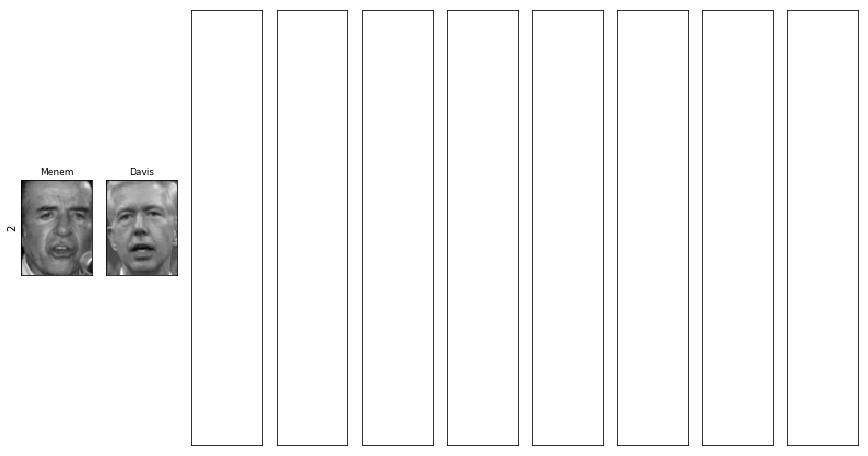

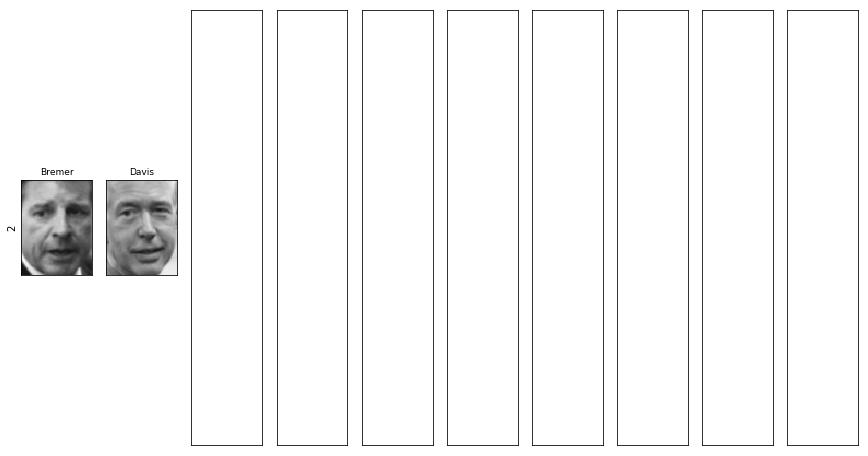

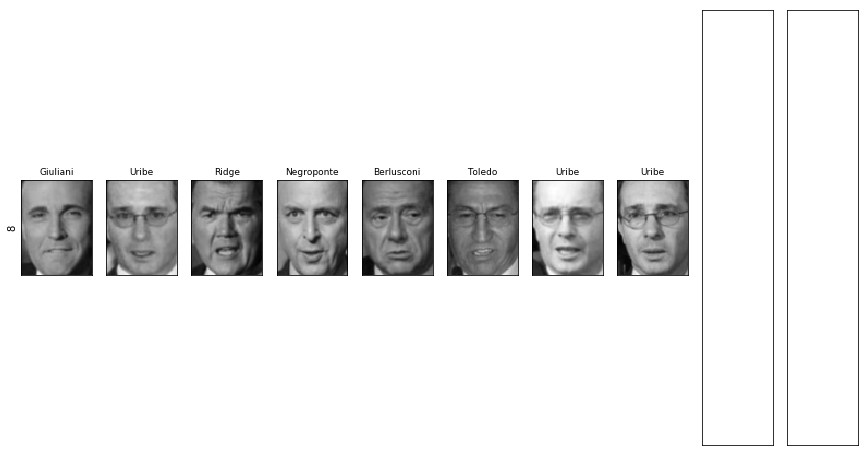

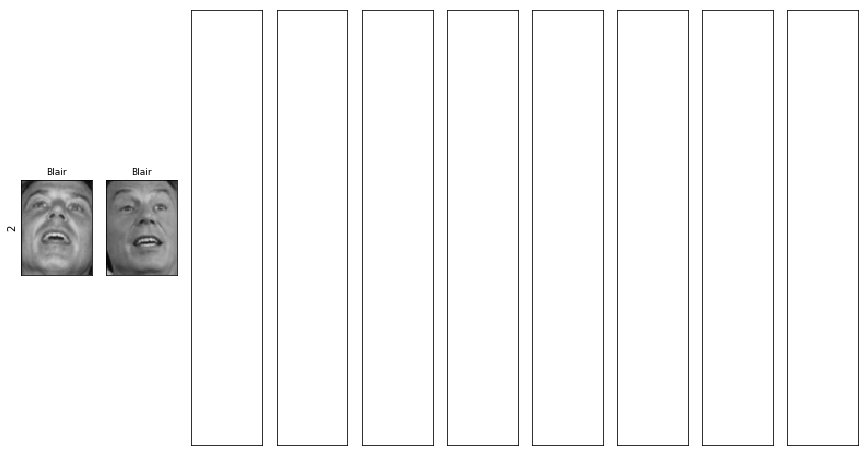

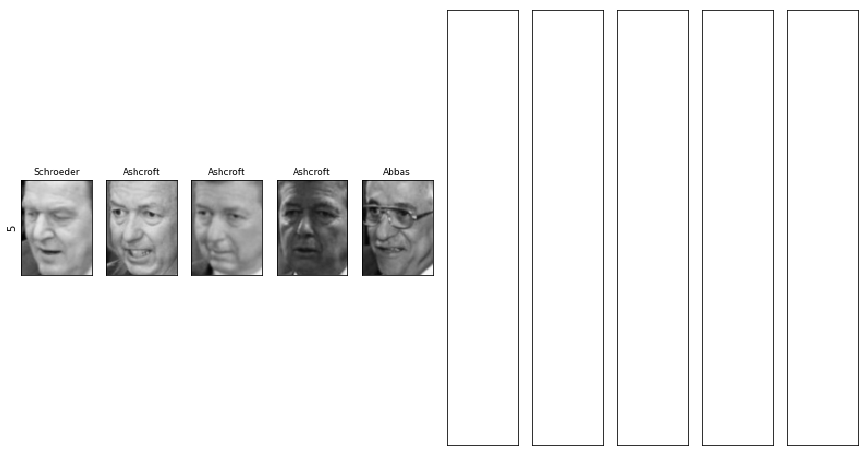

In [88]:
n_clusters = 100
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})
plt.show()        

Można wykonać analogiczną procedurę dla: 

```python
n_clusters=40
```

In [26]:
# extract clusters with ward agglomerative clustering# extrac 
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


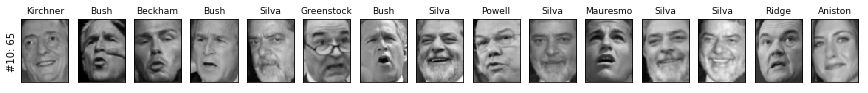

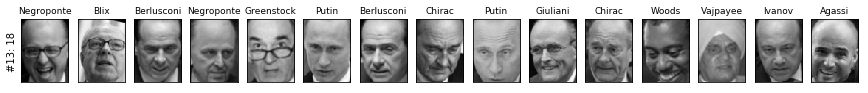

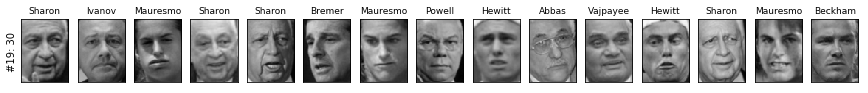

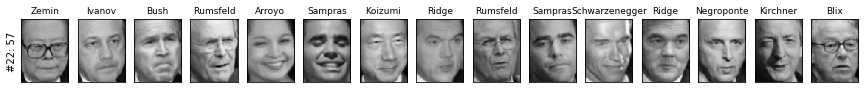

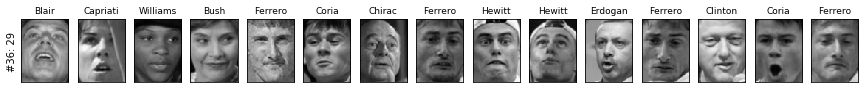

In [27]:
n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gist_gray)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)
plt.show()

# Zadanie 1

Dobierz optymalne parametry dla:
 * k-średnie, 
 * DBSCAN, 
 * hierarhiczne klastrowanie.

In [ ]:
from sklearn import metrics
print("ARI: {:.2f}".format(metrics.adjusted_rand_score(labels_agg, labels_km)))